In this notebook, we keep analyzing log data with a time range of about 1 week (aggregated by an interval of 1 minute).
- In addition to the feature of query count of an example service, an additional feature of error ratio is introduced.
- This example tries to explore the generalizability of the model with more input features.

https://github.com/keras-team/keras-io/blob/master/examples/timeseries/timeseries_anomaly_detection.py

### Setup enviroment

In [3]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from datetime import datetime
from matplotlib import pyplot as plt
from matplotlib import dates as md
from mpl_toolkits.mplot3d import Axes3D
import time

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima_model import ARIMA

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

from sklearn.preprocessing import StandardScaler

from statistics import mean 

import pickle

from preprocess import MySimpleScaler #

import googleapiclient.discovery

import h5py

import functools

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 11, 5

### Import data

In [4]:
arr = np.load('./data/1w_ti5m.npy')

In [5]:
checks   = arr[:,:,0].tolist()
queries  = arr[:,:,1].tolist()
statuses = arr[:,:,3].tolist()

service_count = len(queries)

In [6]:
def normalize(values):
#     mean = np.mean(values)
#     values -= mean
#     std = np.std(values)
#     values /= std
#     return values, mean, std
    vmin = np.min(values)
    vmax = np.max(values)
    values = (values - vmin) / (vmax - vmin)
    return values, _, _

In [7]:
qs            = [[]] * service_count
qs_normalized = [[]] * service_count
#
rs            = [[]] * service_count

for i in range(service_count):
    v, _, _ = normalize(queries[i])
    qs[i]            = np.append(queries[i], [0.0] * (4 - len(v) % 4)) # ugly lol
    qs_normalized[i] = np.append(v,          [0.0] * (4 - len(v) % 4)) # ugly lol
      
    r = (np.array(checks[i]) + np.array(statuses[i])) / np.array(queries[i])
    r = np.nan_to_num(r.tolist()) #
    rs[i]            = np.append(r,          [0.0] * (4 - len(v) % 4))
    
qs            = np.array(qs)
qs_normalized = np.array(qs_normalized)
rs            = np.array(rs)

print(qs.shape)
print(qs.shape == qs_normalized.shape)
print(qs.shape == rs.shape)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


(705, 1944)
True
True


### Time series view: train an Autoencoder model

In [8]:
train_mae_loss_list = [[]] * service_count
test_mae_loss_list  = [[]] * service_count

In [9]:
TIME_STEPS = 12
SLIDE_STEPS = 1

train_test_split = 0.85
train_size = int(qs_normalized.shape[1] * train_test_split)

n_covers = qs_normalized.shape[1] - 1 # strange

In [10]:
# https://github.com/curiousily/Deep-Learning-For-Hackers/blob/master/14.time-series-anomaly-detection.ipynb
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = list(X[i:(i + time_steps)])
        Xs.append(v)        
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

In [11]:
def dl(idx, service, train_test_split, TIME_STEPS):
    # https://github.com/curiousily/Deep-Learning-For-Hackers/blob/master/14.time-series-anomaly-detection.ipynb

    data_0 = qs_normalized[idx].reshape(-1,1)
    data_1= rs[idx].reshape(-1, 1)
    
    # scaler = StandardScaler().fit(data)
    # data = scaler.transform(data)

    train_size = int(data_0.shape[0] * train_test_split)
    train_range = range(0, train_size)
    test_range  = range(0, data_0.shape[0]) #range(train_size, data.shape[0])
    
    train_0 = data_0[train_range]
    test_0  = data_0[test_range]
    X_train_0, y_train_0 = create_dataset(train_0, train_0, TIME_STEPS)
    X_test_0,  y_test_0  = create_dataset(test_0,  test_0,  TIME_STEPS)
    
    train_1 = data_1[train_range]
    test_1  = data_1[test_range]
    X_train_1, y_train_1 = create_dataset(train_1, train_1, TIME_STEPS)
    X_test_1,  y_test_1  = create_dataset(test_1,  test_1,  TIME_STEPS)
    
    X_train = np.concatenate((X_train_0, X_train_1), axis=2)
    X_test  = np.concatenate((X_test_0, X_test_1),   axis=2)
    
    #
    model = keras.Sequential()
    model.add(keras.layers.LSTM(
        units=64, 
        input_shape=(X_train.shape[1], X_train.shape[2])
    ))
    model.add(keras.layers.Dropout(rate=0.2))
    model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
    model.add(keras.layers.LSTM(units=64, return_sequences=True))
    model.add(keras.layers.Dropout(rate=0.2))
    model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
    model.compile(loss='mae', optimizer='adam')
    
    history = model.fit(
        X_train,
        X_train,
        epochs=100,
        batch_size=32,
        validation_split=0.1,
        verbose=0,
        # callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")],
    )
    
    #
    X_train_pred = model.predict(X_train)
    train_mae_loss = np.mean(np.mean(np.abs(X_train_pred - X_train), axis=1), axis=1)
    train_mae_loss_list[idx] = train_mae_loss #
    
    X_test_pred = model.predict(X_test)
    test_mae_loss = np.mean(np.mean(np.abs(X_test_pred - X_test),    axis=1), axis=1)
    test_mae_loss_list[idx] = test_mae_loss #
    
    #
    xtrp_0 = X_train_pred[:,-1,0].reshape(-1,1)
    xtep_0 = X_test_pred[:,-1,0].reshape(-1,1)
    
    xtrp_1 = X_train_pred[:,-1,1].reshape(-1,1)
    xtep_1 = X_test_pred[:,-1,1].reshape(-1,1)
    
    #
    f, axes = plt.subplots(1, 3, figsize=(22, 5), sharex=False)
    
    axes[0].plot(history.history['loss'], label='train')
    axes[0].plot(history.history['val_loss'], label='validation')
    axes[0].legend()
    
    sns.distplot(train_mae_loss, bins=50, kde=True, ax=axes[1]).set_title('train mae loss')
    
    sns.distplot(test_mae_loss, bins=50, kde=True, ax=axes[2]).set_title('test mae loss')
    
    f_, axes_ = plt.subplots(figsize=(22, 5), sharex=False)
    err0 = xtep_0 - test_0[TIME_STEPS-1:-1]
    plt.plot(test_range,  test_0,  label='test')
    plt.plot(test_range[TIME_STEPS-1:-1],  xtep_0, label='test pred')
    plt.scatter(test_range[TIME_STEPS-1:-1],  err0,  c=err0, label='test pred error')
    plt.legend()
    plt.xlabel("Time step")
    plt.ylabel("Normalized query count")
    plt.axvline(x=train_size, color='r')
    plt.ylim(-1., 1.)
    
    plt.title('service: {}'.format(service))
    plt.show()
    
    f_, axes_ = plt.subplots(figsize=(22, 5), sharex=False)
    err1 = xtep_1 - test_1[TIME_STEPS-1:-1]
    plt.plot(test_range,  test_1,  label='test')
    plt.plot(test_range[TIME_STEPS-1:-1],  xtep_1, label='test pred')
    plt.scatter(test_range[TIME_STEPS-1:-1],  err1,  c=err1, label='test pred error')
    plt.legend()
    plt.xlabel("Time step")
    plt.ylabel("Error ratio")
    plt.axvline(x=train_size, color='r')
    plt.ylim(-1., 1.)
    
    plt.title('service: {}'.format(service))
    plt.show()
    
    return model, train_mae_loss, X_test, X_test_pred

In [12]:
def post_avg(ori, test_pred): 
    ori = ori.reshape(-1)

    lss        = [[] for _ in range(n_covers)]
    pred_avgs  = [[] for _ in range(n_covers)]

    d = test_pred
    for i0 in range(len(d)):
        for i1 in range(len(d[0])):
            lss[i0 + (SLIDE_STEPS - 1) + i1].append(d[i0][i1])

    for i, ls in enumerate(lss):
        # if i % 100 == 0: print(i, ls)
        pred_avgs[i] = mean(ls)

    test_pred_avg = list(pred_avgs)

    s = 0
    for i in range(train_size, n_covers):
        s += abs(pred_avgs[i] - ori[i]) # absolute val
    errs_no_train = s / (n_covers - train_size) 
    
    return test_pred_avg, errs_no_train

In [13]:
idx = 21 # used to be 40, changed due to reloading data
service = 'service: autopush-healthcare.sandbox.googleapis.com'

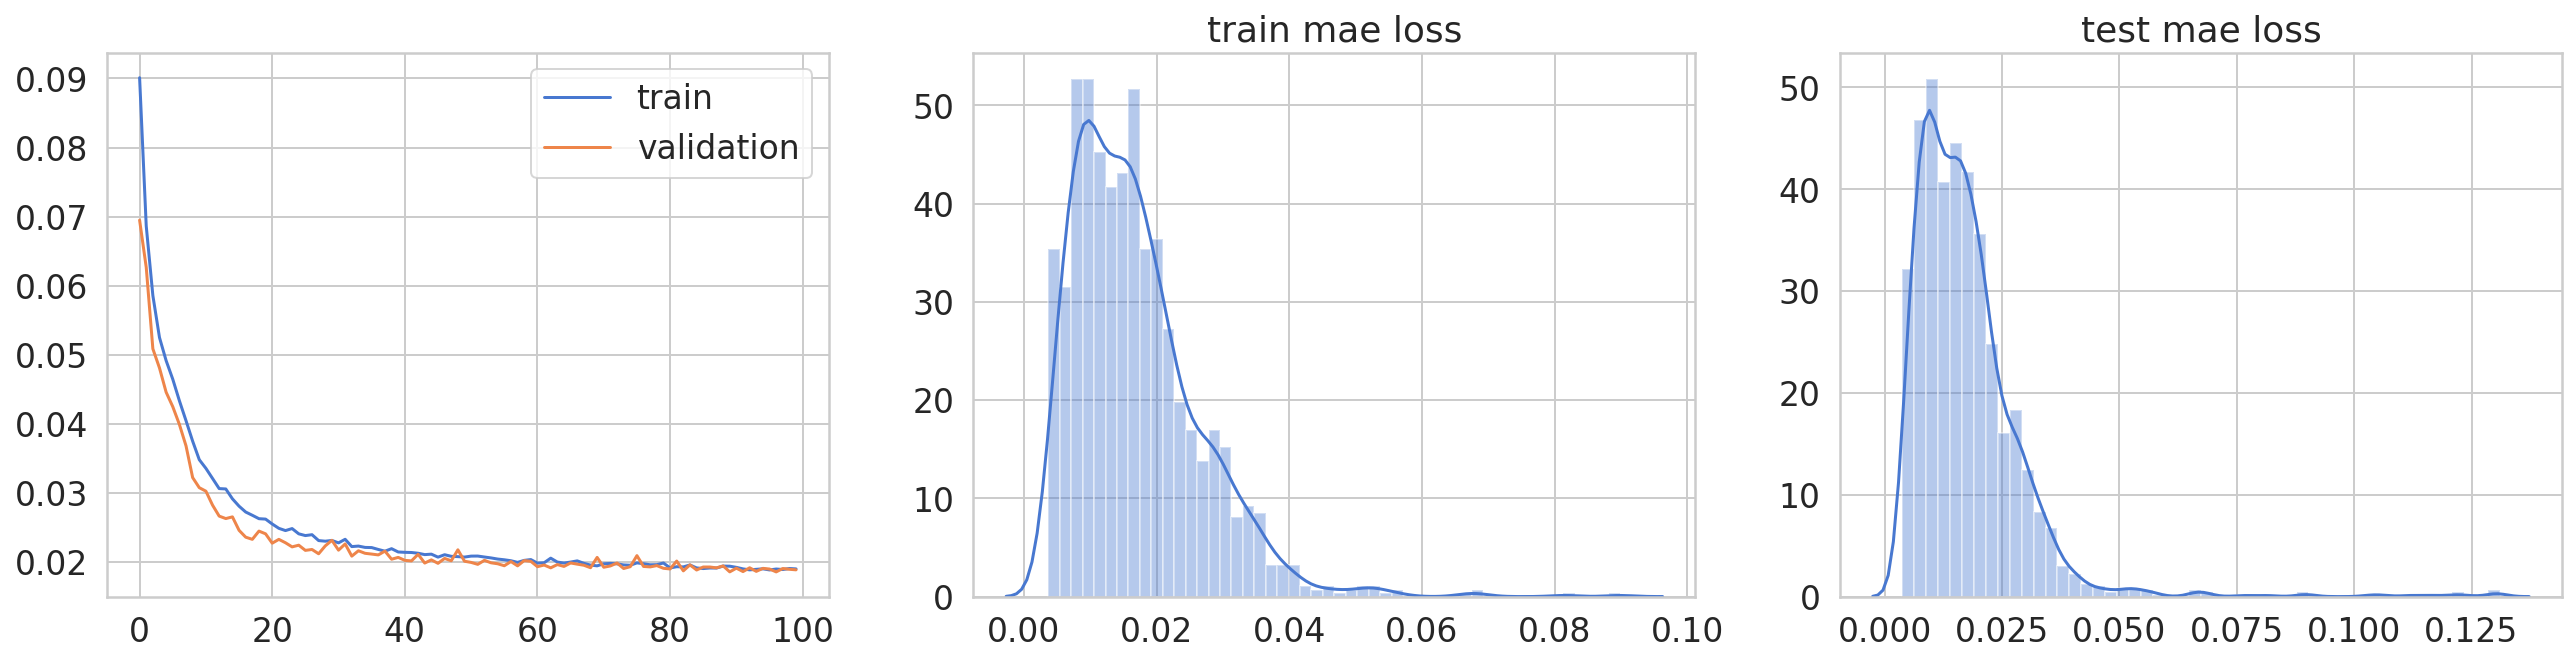

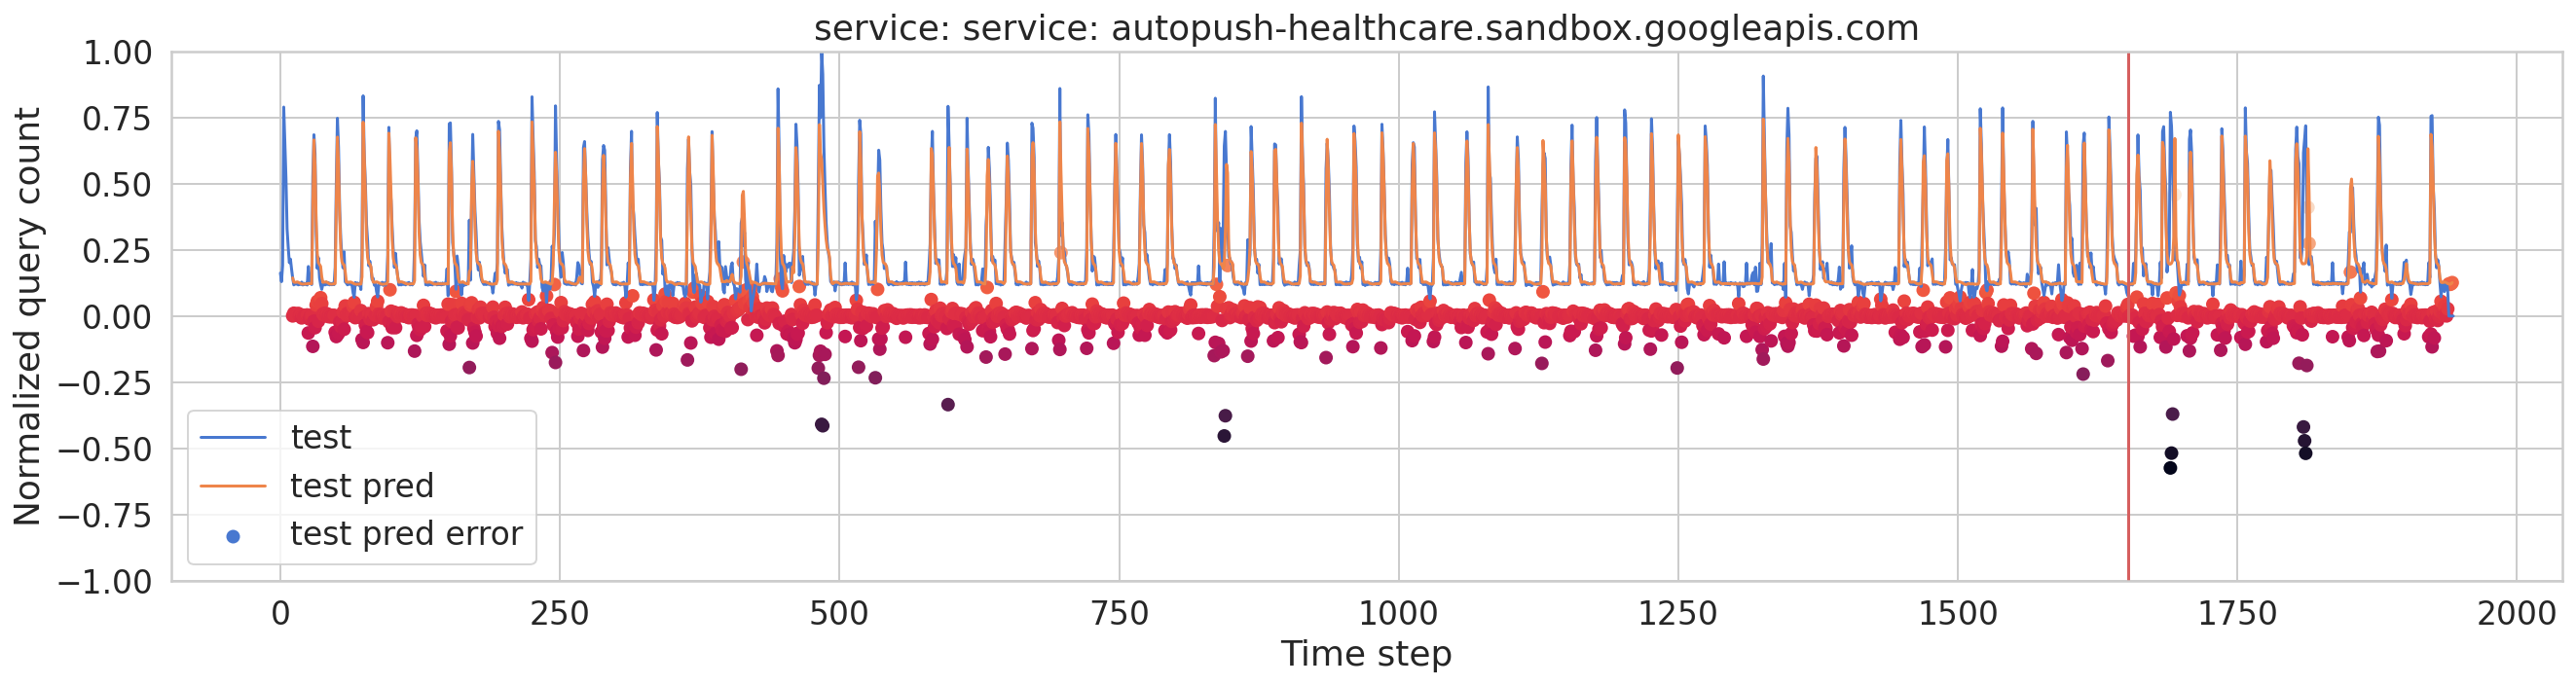

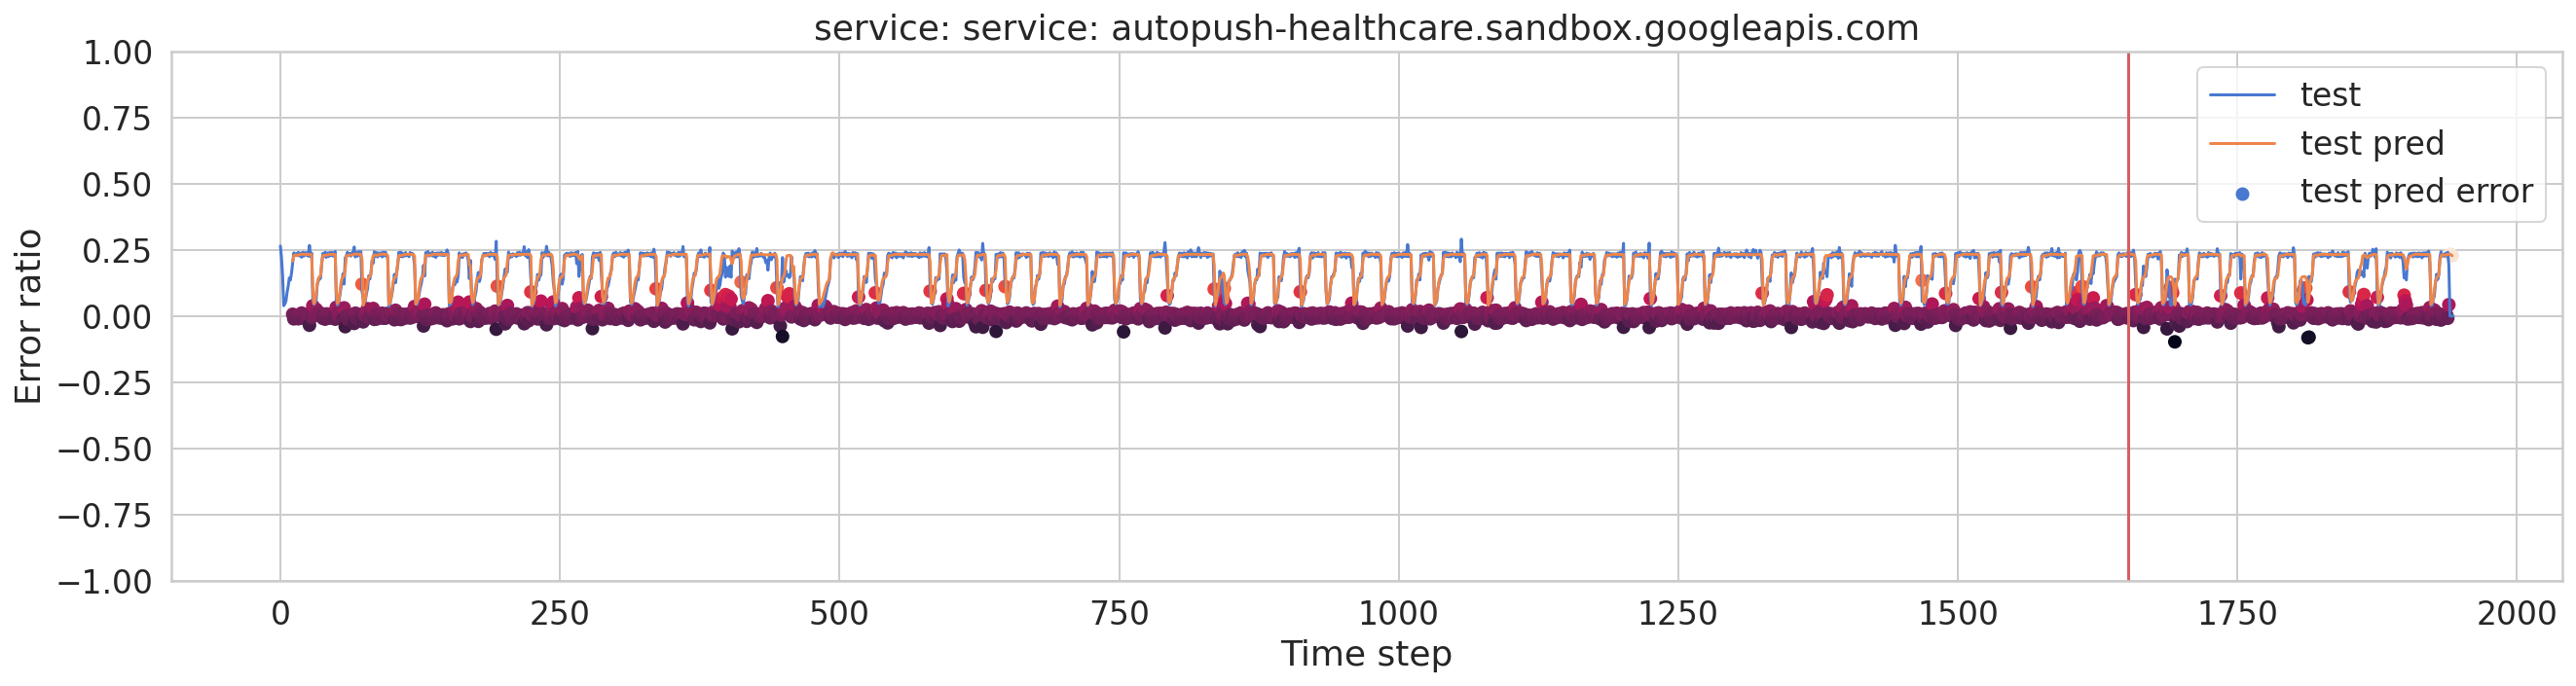

In [14]:
model, train_mae_loss, X_test, X_test_pred = dl(idx=idx, service=service, train_test_split=train_test_split, TIME_STEPS=TIME_STEPS)

In [15]:
def make_prediction(data_0=qs_normalized[idx].reshape(-1,1), 
                    data_1=rs[idx].reshape(-1,1), 
                    titles=['', '']):
    t0 = time.time()
    
    # pre-processing
    train_size = int(data_0.shape[0] * train_test_split)
    test_range  = range(0, data_0.shape[0]) #range(train_size, data.shape[0])
    
    test_0  = data_0[test_range]
    X_test_0, _ = create_dataset(test_0, test_0, TIME_STEPS)
    
    test_1  = data_1[test_range]
    X_test_1, _ = create_dataset(test_1, test_1, TIME_STEPS)
    
    X_test  = np.concatenate((X_test_0, X_test_1),   axis=2)

    # predict
    test_pred = model.predict(X_test)

    # post-processing
    test_pred_avg_0, errs_no_train_0 = post_avg(ori=data_0, test_pred=test_pred[:,:,0])
    test_pred_avg_1, errs_no_train_1 = post_avg(ori=data_1, test_pred=test_pred[:,:,1])
    
    err_0 = data_0[train_size:-1] - np.array(test_pred_avg_0[train_size:]).reshape(-1,1)
    err_1 = data_1[train_size:-1] - np.array(test_pred_avg_1[train_size:]).reshape(-1,1)
    
    
    f_, axes_ = plt.subplots(figsize=(22, 5), sharex=False)
    plt.plot(data_0[:-1], label='observed')
    plt.plot(test_pred_avg_0, label='predicted')
    err_0 = data_0[:-1] - np.array(test_pred_avg_0).reshape(-1,1)
    plt.scatter(range(err_0.shape[0]),  err_0,  c=err_0, label='pred error')
    plt.legend()
    plt.axvline(x=train_size, color='r')
    plt.ylim(-1., 1.5)
    plt.title(titles[0])
    plt.xlabel('(5 min) time interval')
    plt.ylabel('Normalized query count')
    
    f_, axes_ = plt.subplots(figsize=(22, 5), sharex=False)
    plt.plot(data_1[:-1], label='observed')
    plt.plot(test_pred_avg_1, label='predicted')
    err_1 = data_1[:-1] - np.array(test_pred_avg_1).reshape(-1,1)
    plt.scatter(range(err_1.shape[0]),  err_1,  c=err_1, label='pred error')
    plt.legend()
    plt.axvline(x=train_size, color='r')
    plt.ylim(-1., 1.5)
    plt.title(titles[1])
    plt.xlabel('(5 min) time interval')
    plt.ylabel('Error ratio')
    
    
    print('{}, {}, avg mae {:.3}'.format(titles[0], titles[1], (errs_no_train_0 + errs_no_train_1) / 2))
    
    '''
    f_, axes_ = plt.subplots(1, 2, figsize=(22, 5), sharex=False)
    
    axes_[0].plot(range(train_size, n_covers), data_0[train_size:-1], label='observed')
    axes_[0].plot(range(train_size, n_covers), test_pred_avg_0[train_size:], label='predicted')
    axes_[0].scatter(range(train_size, n_covers),   err_0,  c=err_0, label='pred error')
    axes_[0].legend()
    #plt.axvline(x=train_size, color='r')
    axes_[0].set_ylim(-1., 1.5)
    #axes_[0].set_title(titles[0] + ', avg test mae: {:.3}'.format(errs_no_train_0))
    axes_[0].set_xlabel('(5 min) time interval')
    axes_[0].set_ylabel('normalized query count')

    axes_[1].plot(range(train_size, n_covers), data_1[train_size:-1], label='observed')
    axes_[1].plot(range(train_size, n_covers), test_pred_avg_1[train_size:], label='predicted')
    axes_[1].scatter(range(train_size, n_covers),   err_1,  c=err_1, label='pred error')
    axes_[1].legend()
    #plt.axvline(x=train_size, color='r')
    axes_[1].set_ylim(-1., 1.)
    #axes_[1].set_title(titles[1] + ', avg test mae: {:.3}'.format(errs_no_train_1))
    axes_[1].set_xlabel('(5 min) time interval')
    axes_[1].set_ylabel('error ratio')
    '''
    
    t1 = time.time()
    print('Elapsed time is {:.2} sec'.format(t1 - t0))

In [16]:
# idx 21
d_0 = np.copy(qs_normalized[idx].reshape(-1,1))
d_1 = np.copy(rs[idx].reshape(-1,1))

# 1) peak twice as high
d_01 = np.copy(d_0)
d_11 = np.copy(d_1)

for i, q in enumerate(d_01):
    if i > train_size:
        d_01[i]  = 2 * q
        d_11[i] *= 2
        
# 2) peak is half
d_02 = np.copy(d_0)
d_12 = np.copy(d_1)

for i, q in enumerate(d_02):
    if i > train_size:
        d_02[i]  = 1/2 * q
        d_12[i] *= 1/2
        
# 3) peak is twice as dense
d_03 = np.copy(d_0)
d_13 = np.copy(d_1)

for i, q in enumerate(d_03):
    if i > train_size:
        ni = ((i - train_size) * 2) % (d_03.shape[0] - train_size) + train_size
        d_03[i] = d_0[ni]
        d_13[i] = d_1[ni]
        
# 4) peak offset (by 64)
d_04 = np.copy(d_0)
d_14 = np.copy(d_1)

for i, q in enumerate(d_04):
    if i > train_size:
        ni = ((i - train_size) + 64) % (d_04.shape[0] - train_size) + train_size
        d_04[i] = d_0[ni]
        d_14[i] = d_1[ni]

service: autopush-healthcare.sandbox.googleapis.com, service: autopush-healthcare.sandbox.googleapis.com, avg mae 0.0207
Elapsed time is 0.53 sec
peak twice as high, no change, avg mae 0.0897
Elapsed time is 0.53 sec
peak half as high, no change, avg mae 0.0415
Elapsed time is 0.53 sec
peak twice as dense, no change, avg mae 0.0657
Elapsed time is 0.54 sec
peak offset, no change, avg mae 0.0548
Elapsed time is 0.53 sec


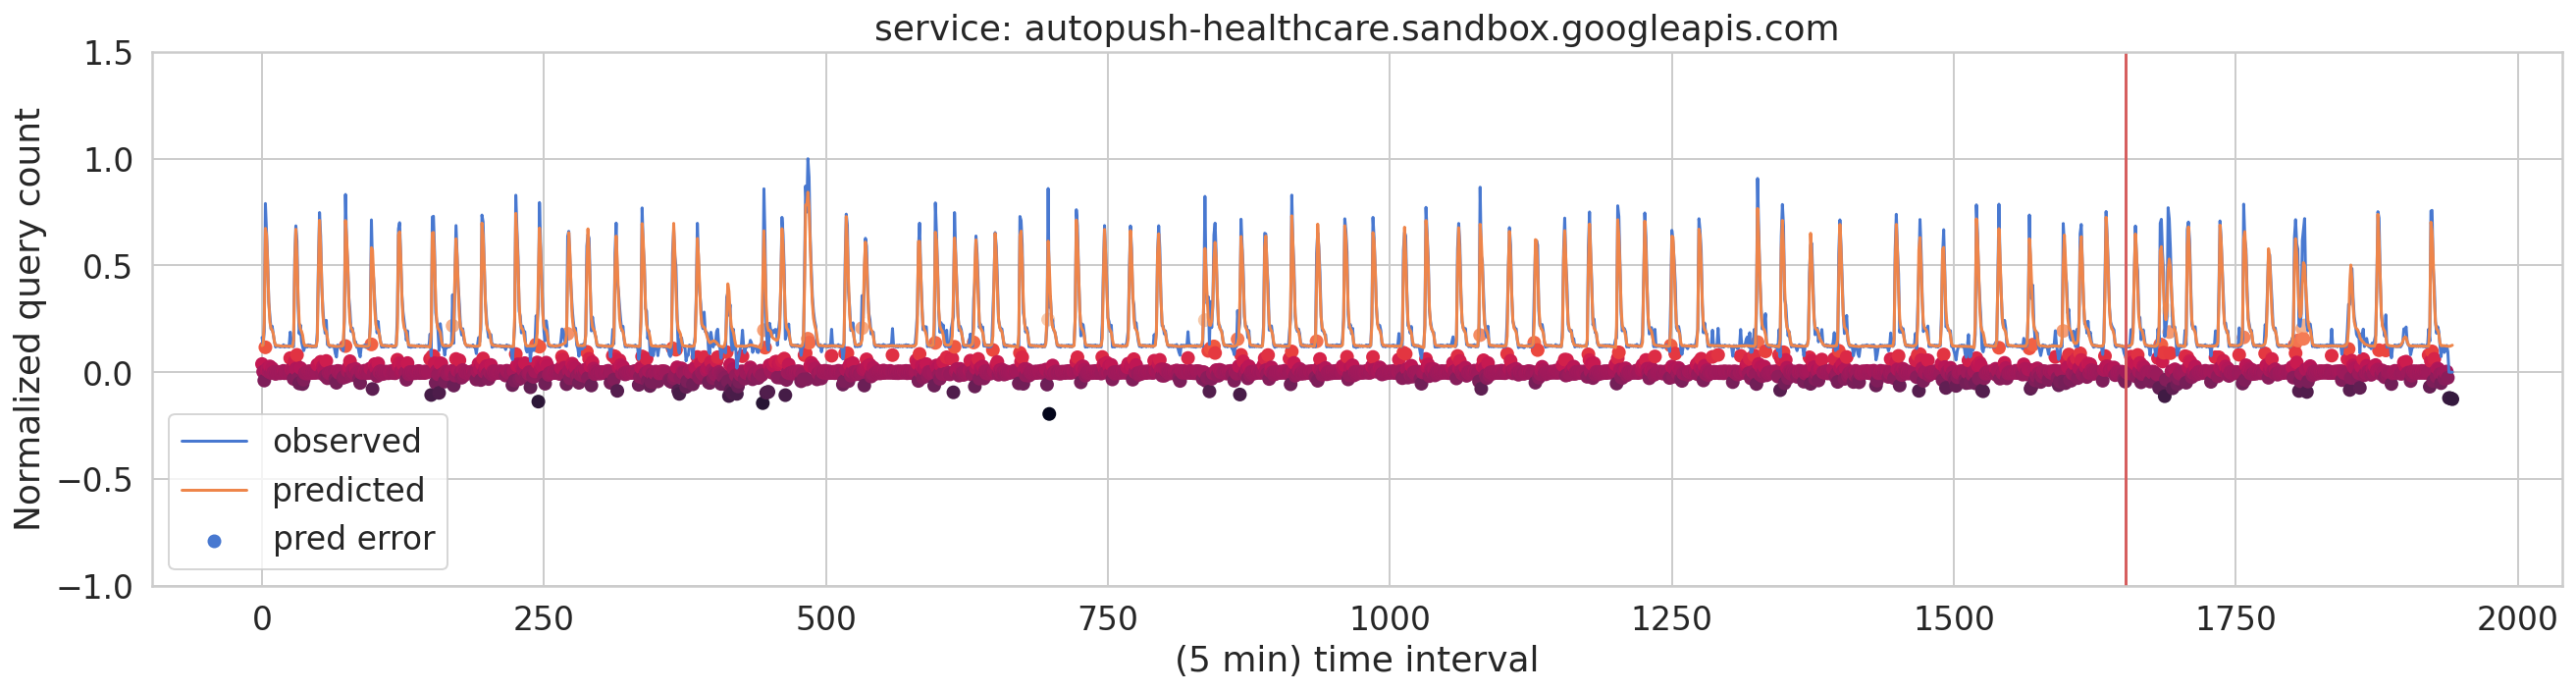

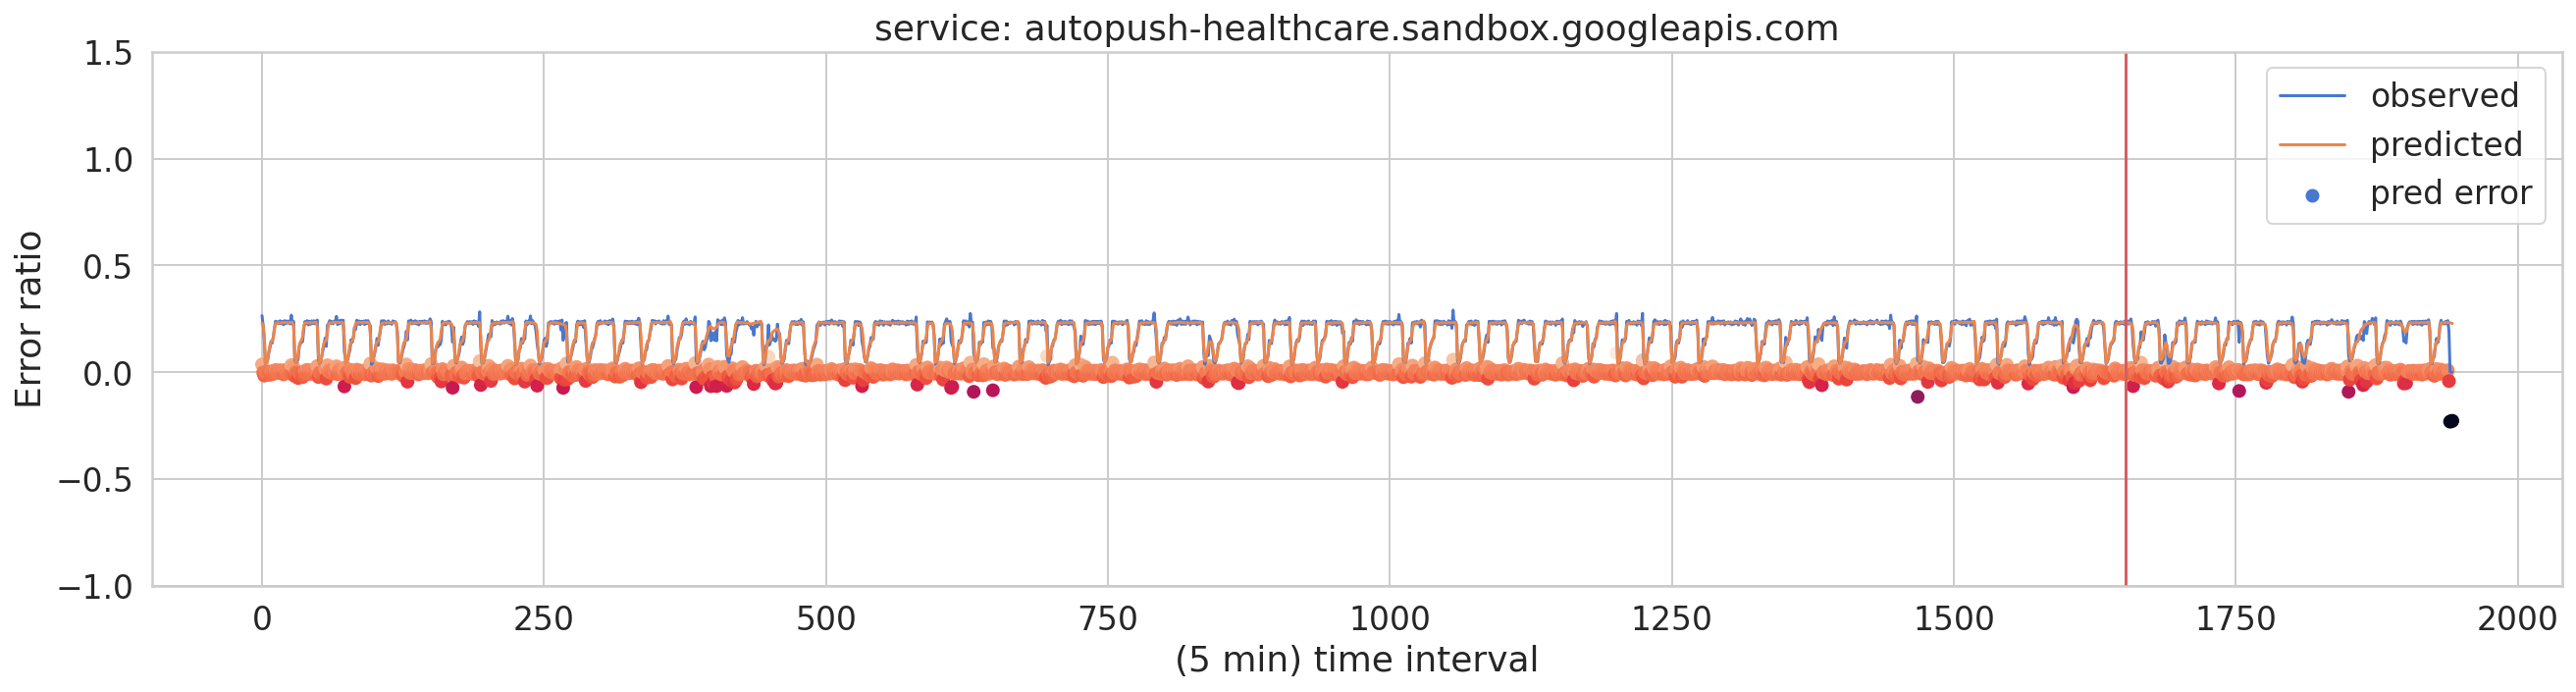

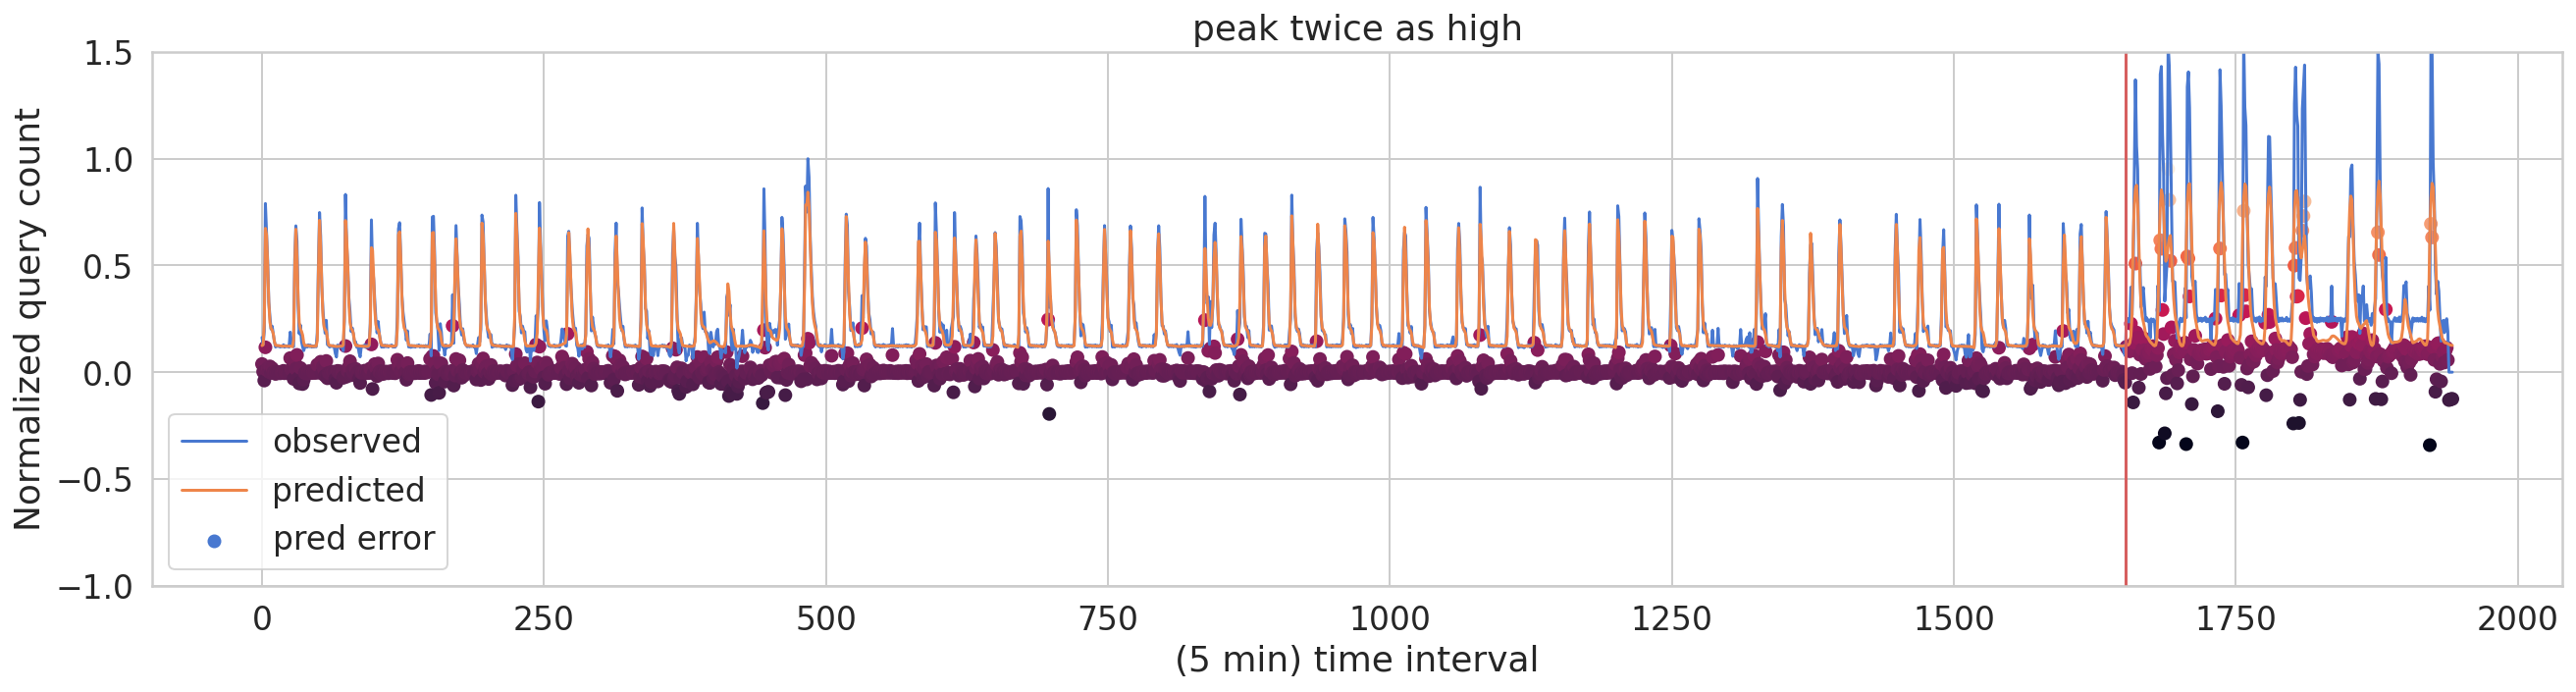

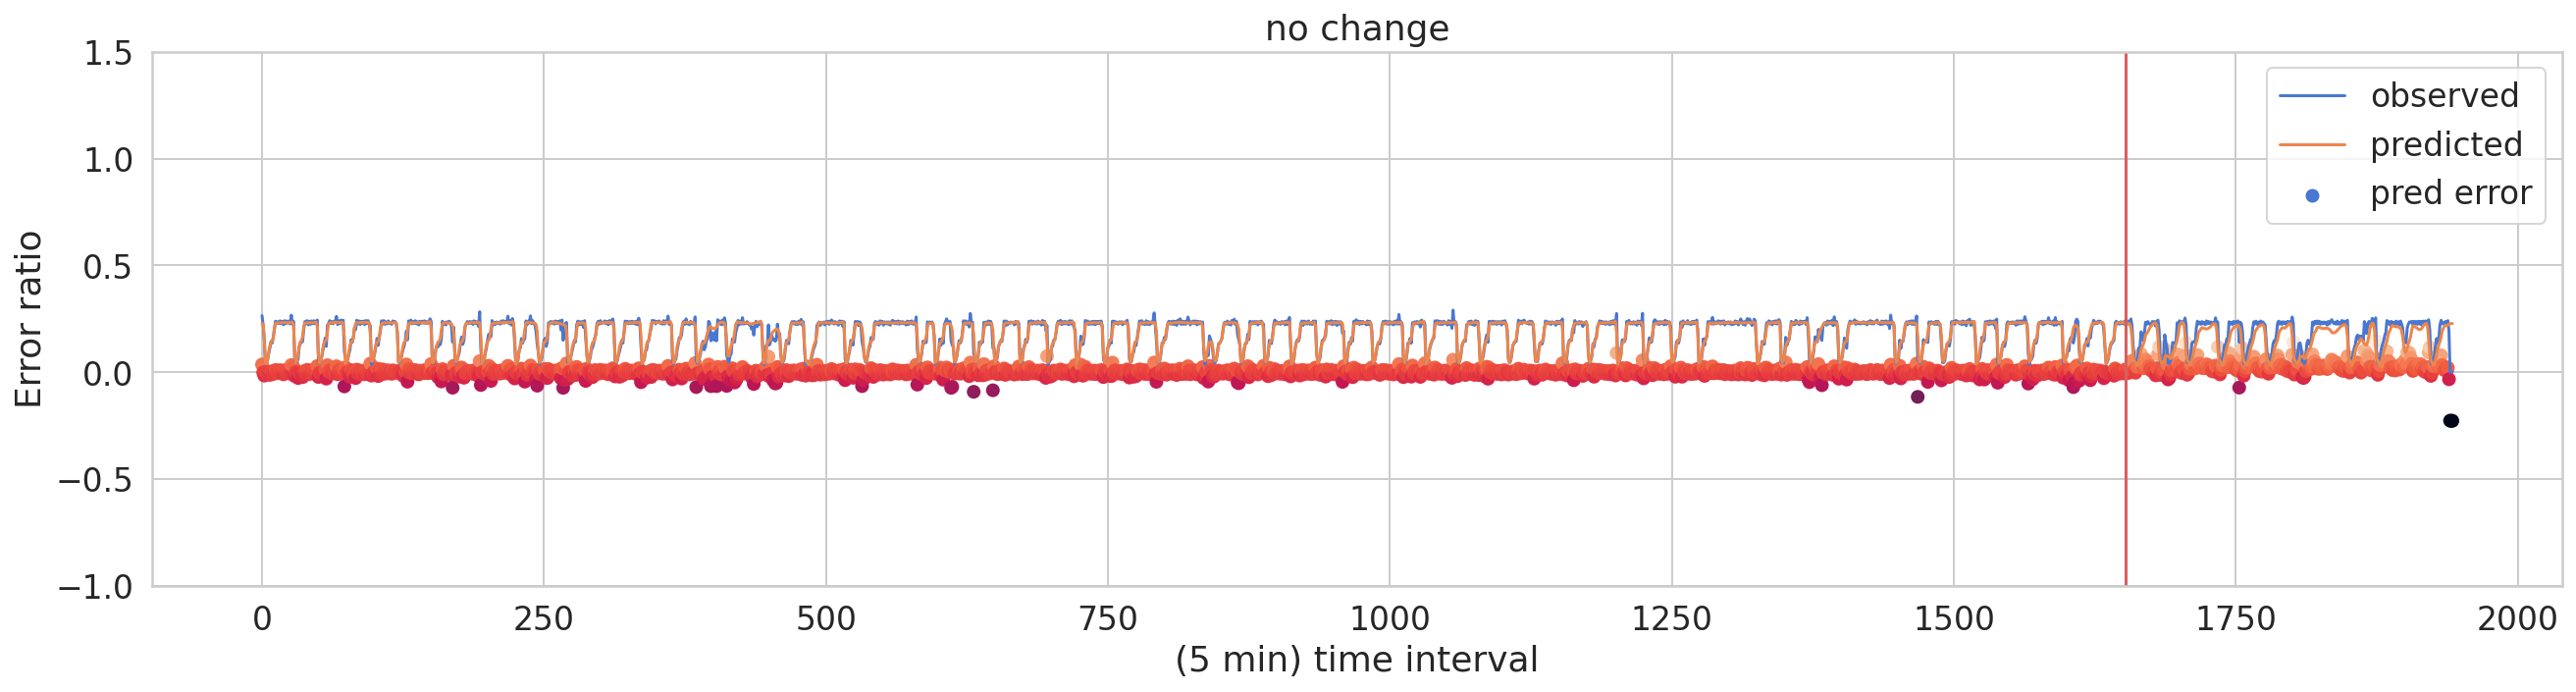

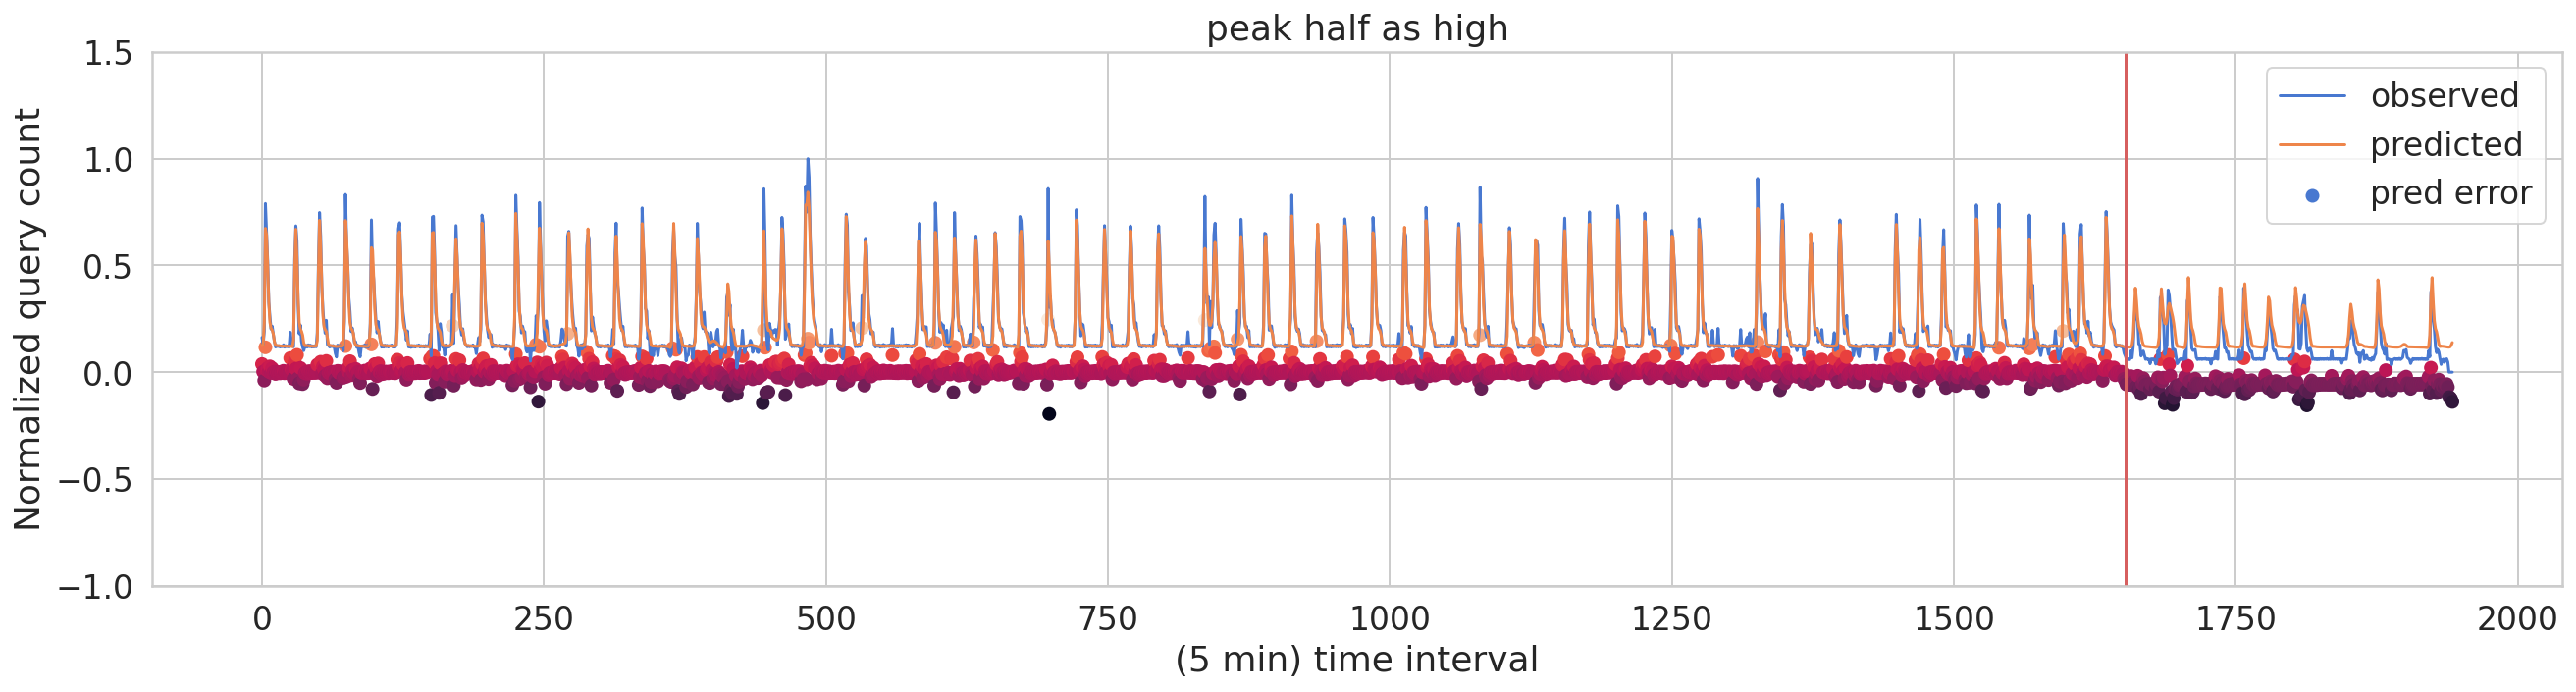

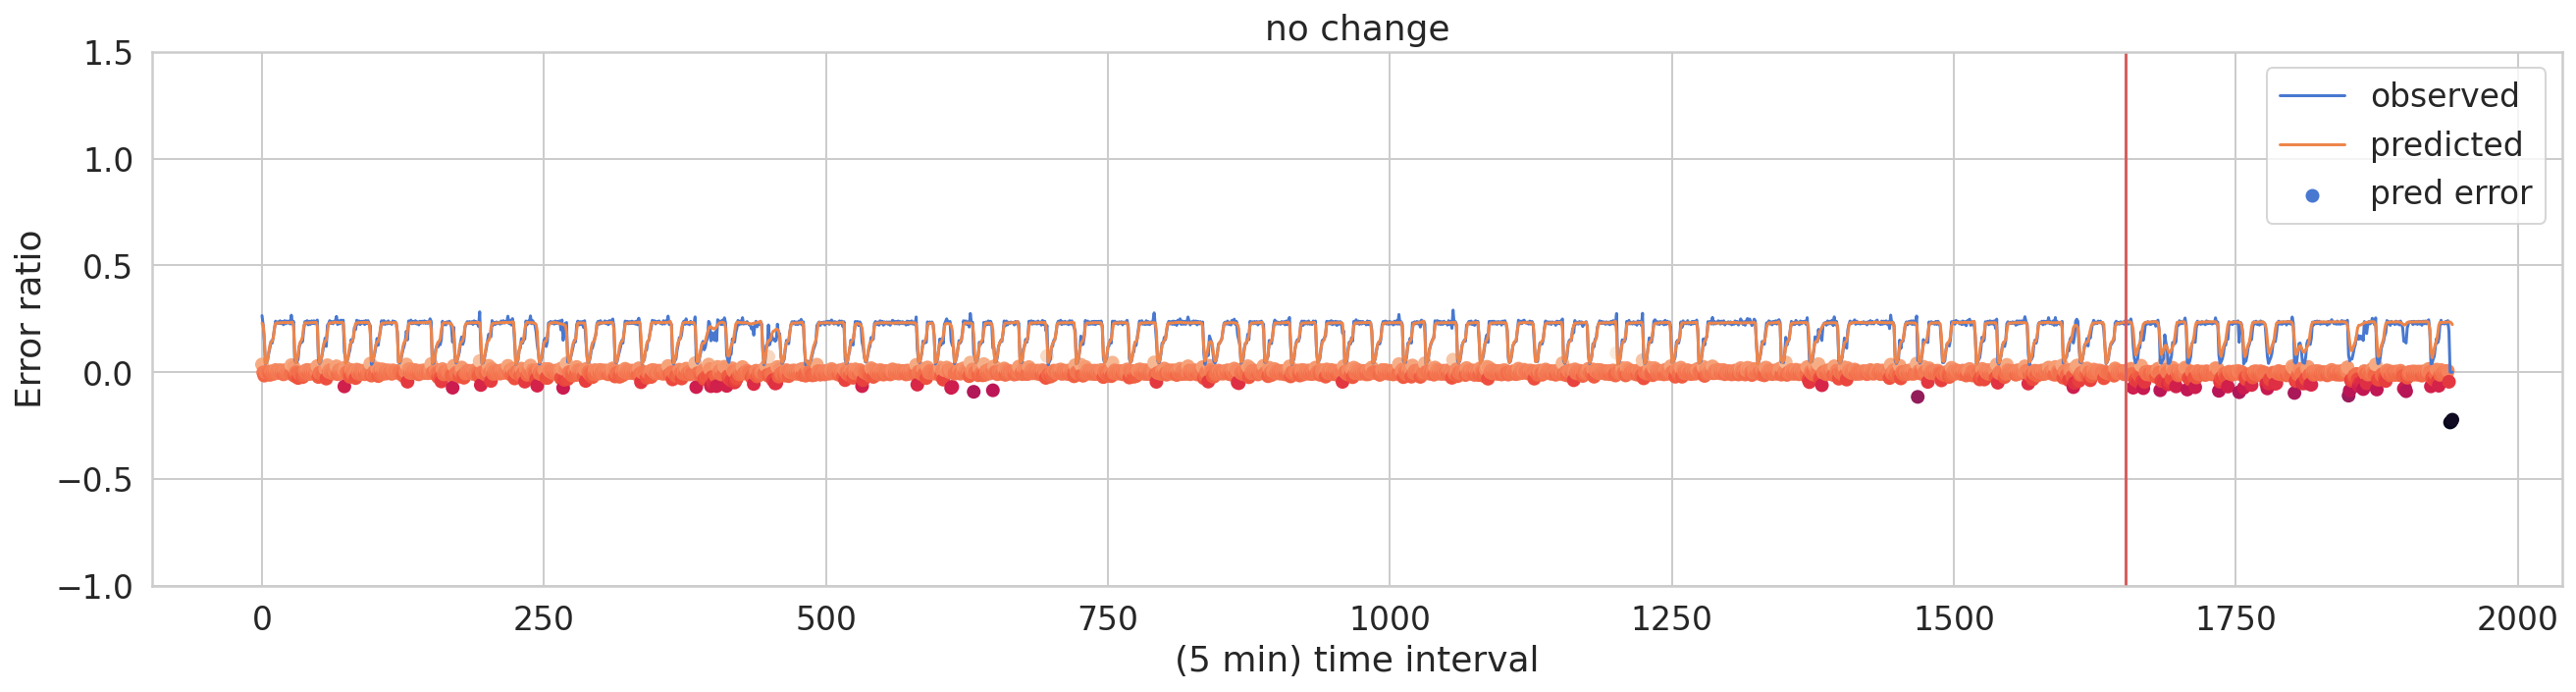

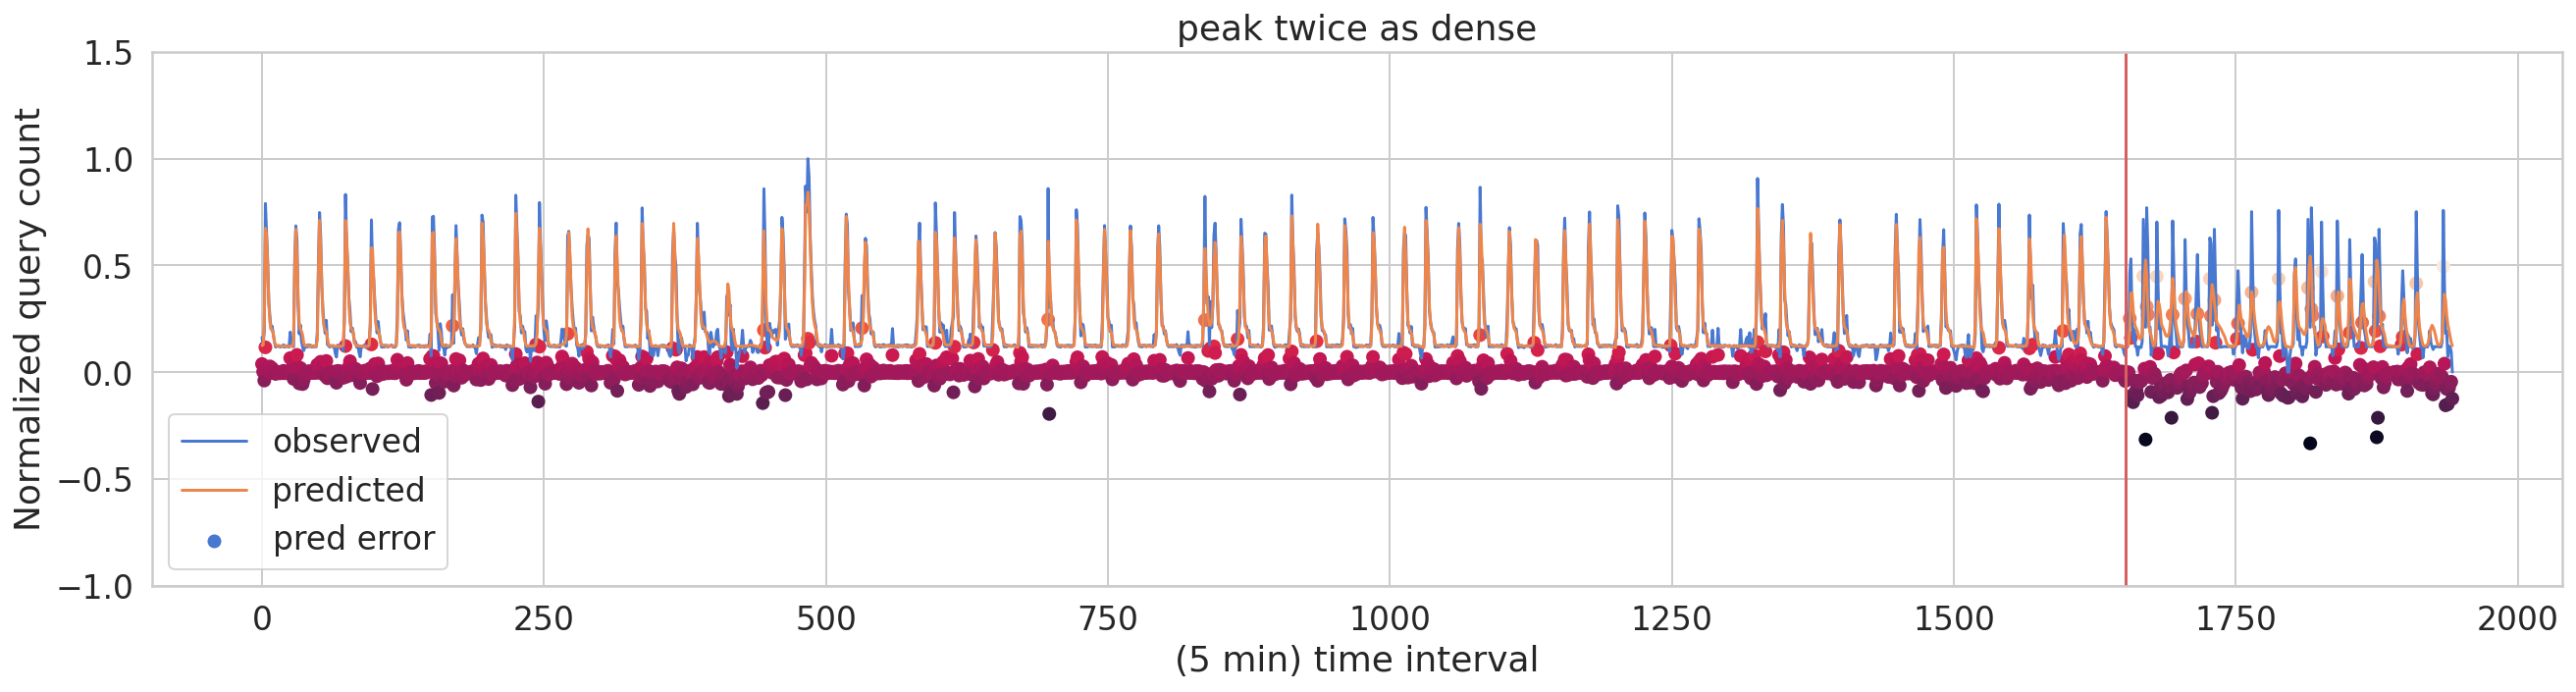

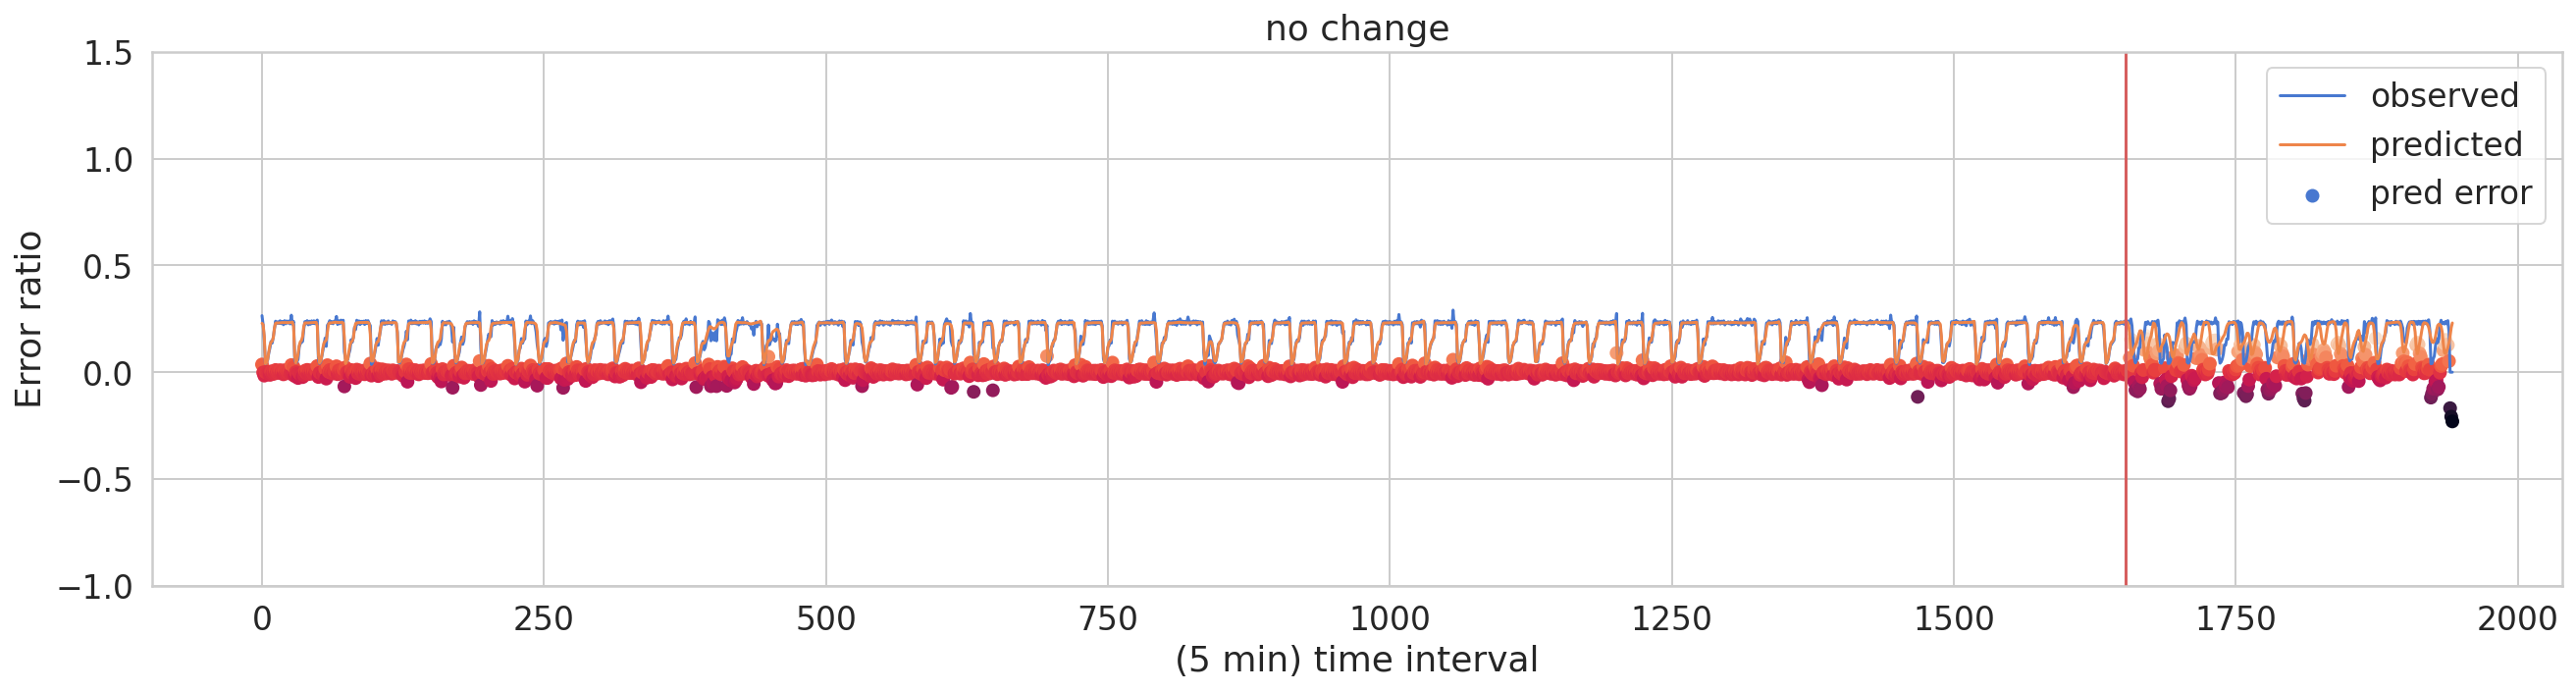

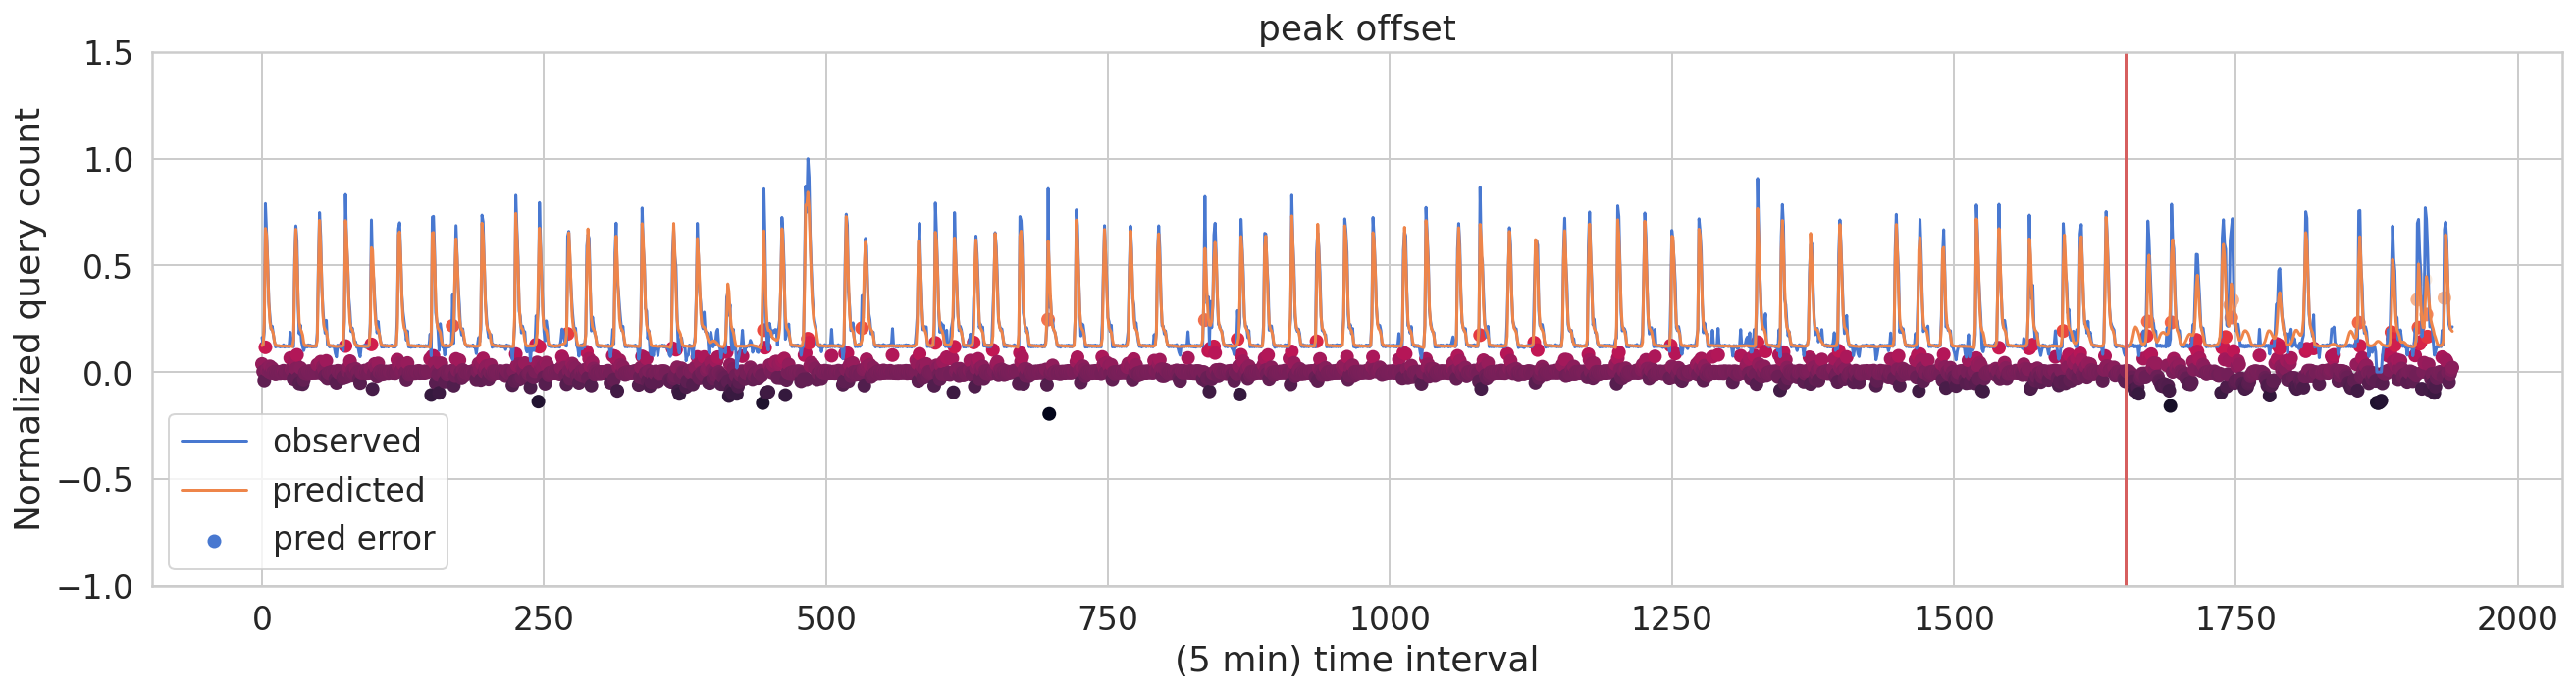

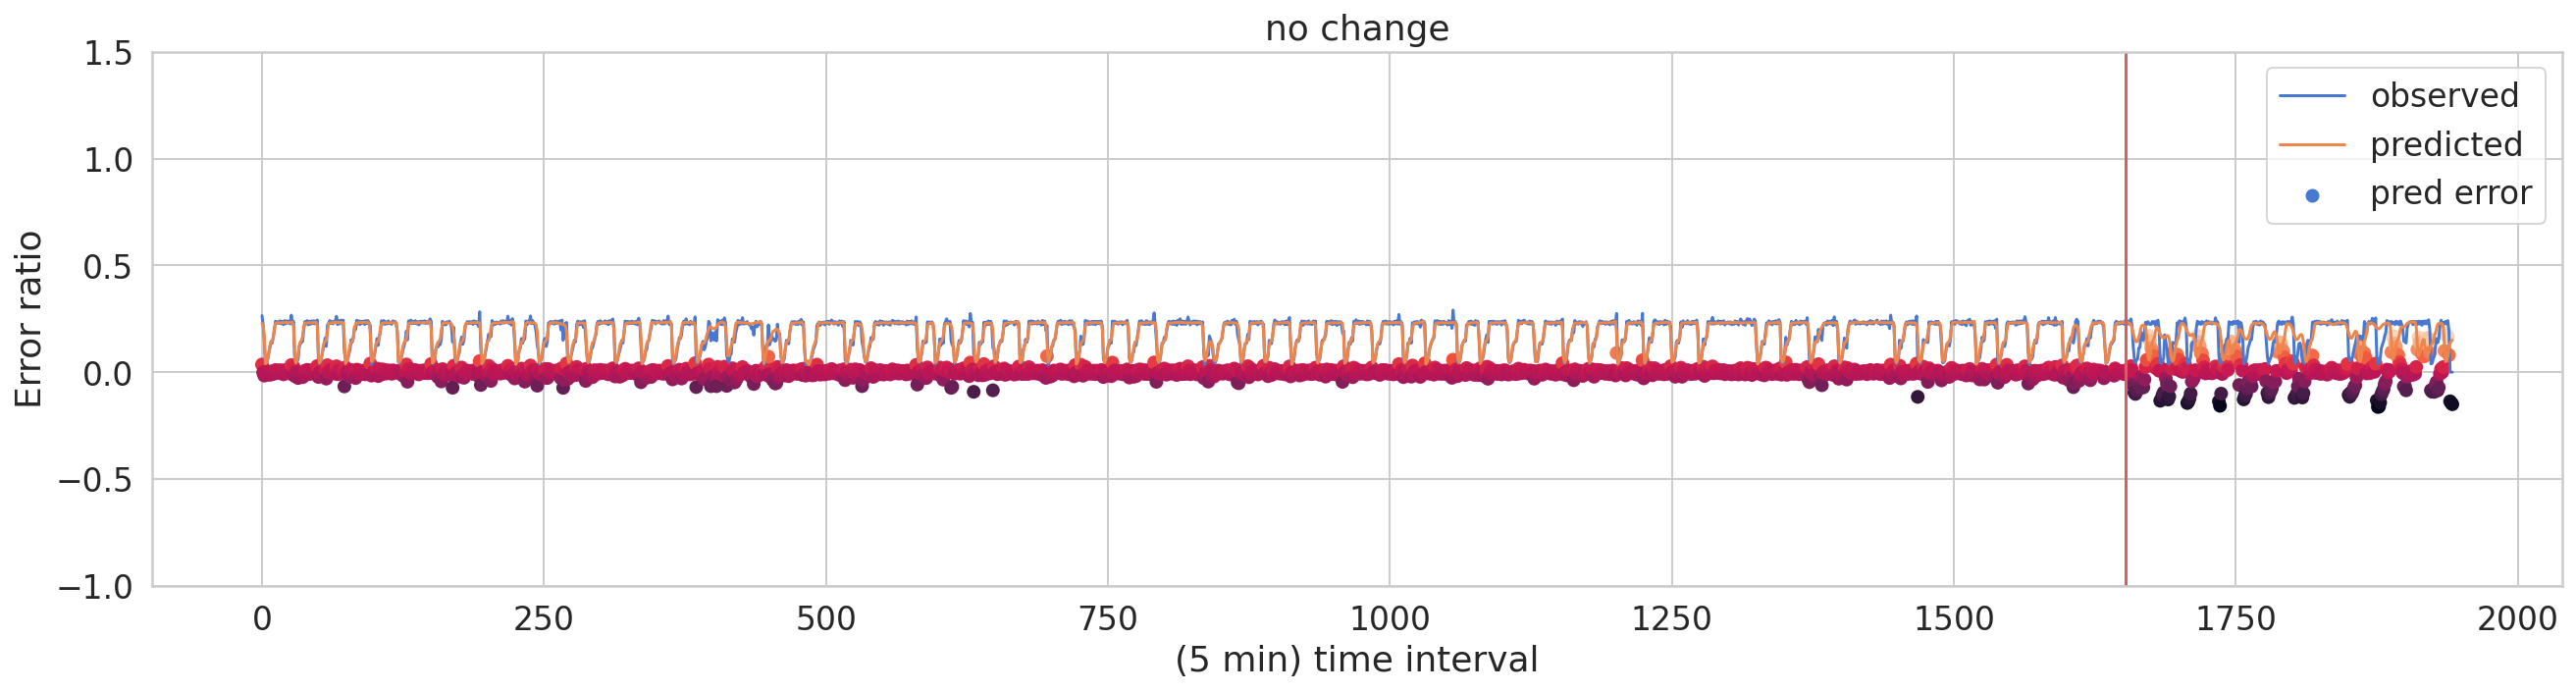

In [17]:
# change qpi only
make_prediction(data_0=d_0,  titles=[service,               service])
make_prediction(data_0=d_01, titles=['peak twice as high',  'no change'])
make_prediction(data_0=d_02, titles=['peak half as high',   'no change'])
make_prediction(data_0=d_03, titles=['peak twice as dense', 'no change'])
make_prediction(data_0=d_04, titles=['peak offset',         'no change'])

service: autopush-healthcare.sandbox.googleapis.com, service: autopush-healthcare.sandbox.googleapis.com, avg mae 0.0207
Elapsed time is 0.79 sec
peak twice as high, plateau twice as high, avg mae 0.177
Elapsed time is 0.53 sec
peak half as high, plateau half as high, avg mae 0.0824
Elapsed time is 0.53 sec
peak twice as dense, plateau twice as dense, avg mae 0.043
Elapsed time is 0.53 sec
peak offset, plateau offest, avg mae 0.0214
Elapsed time is 0.53 sec


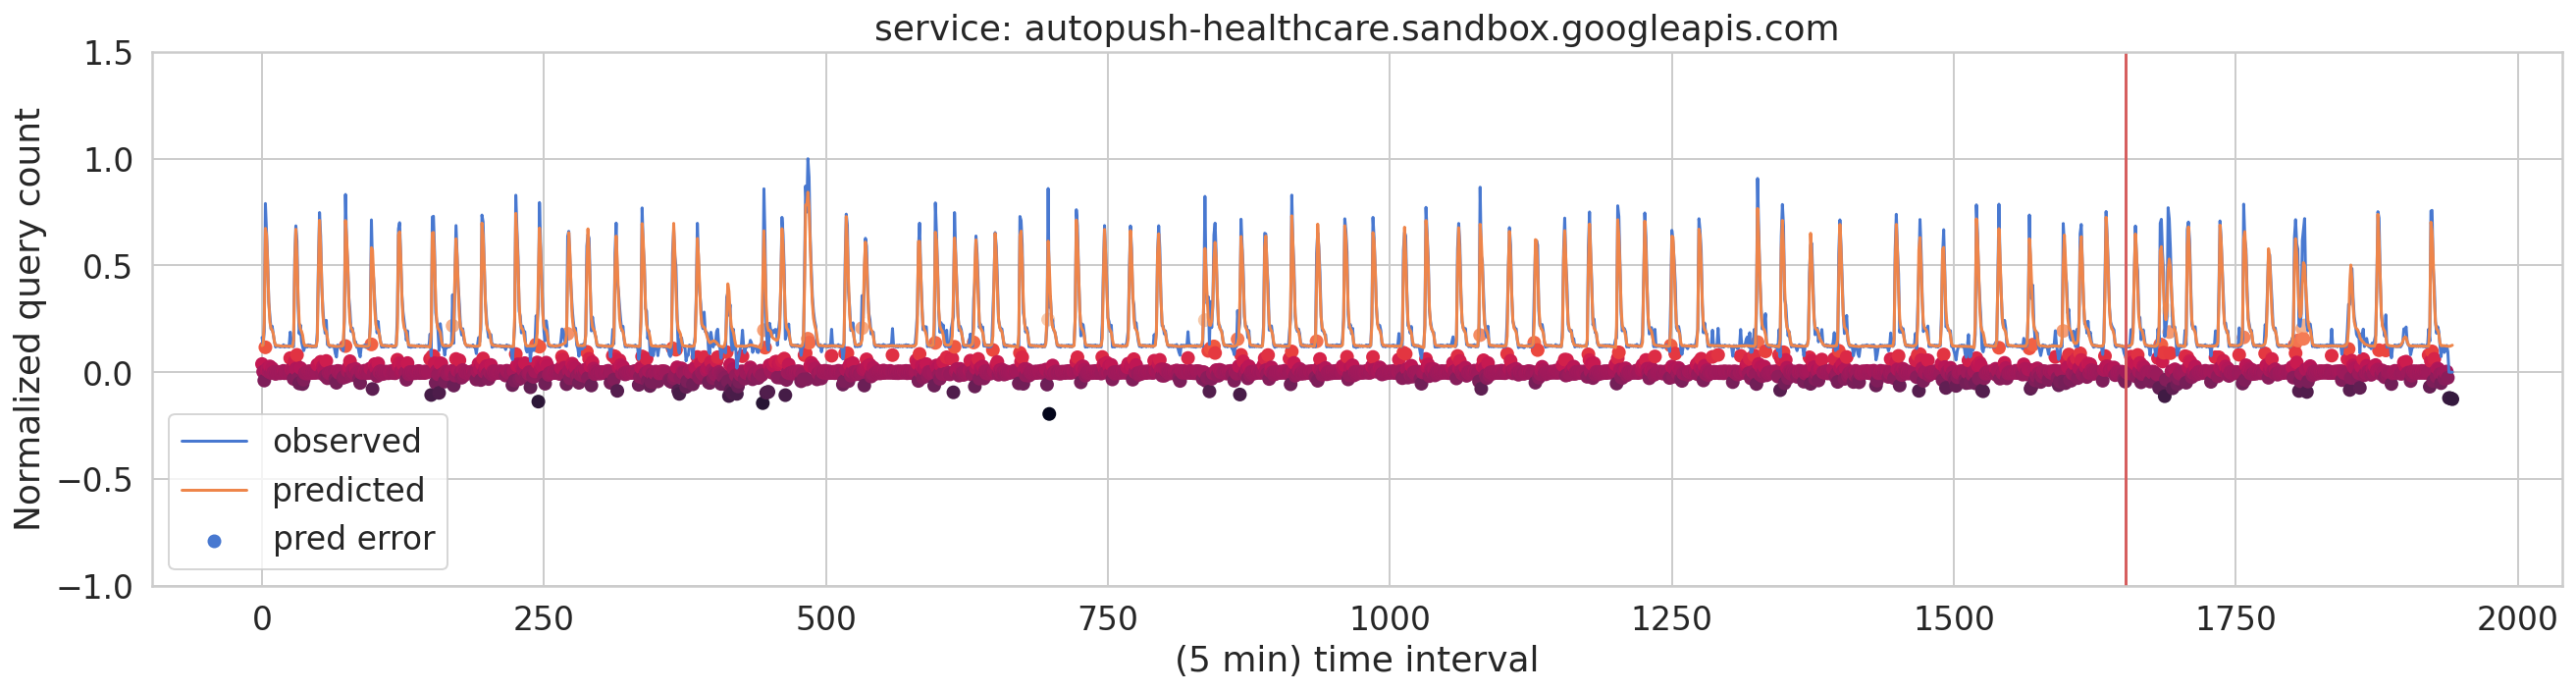

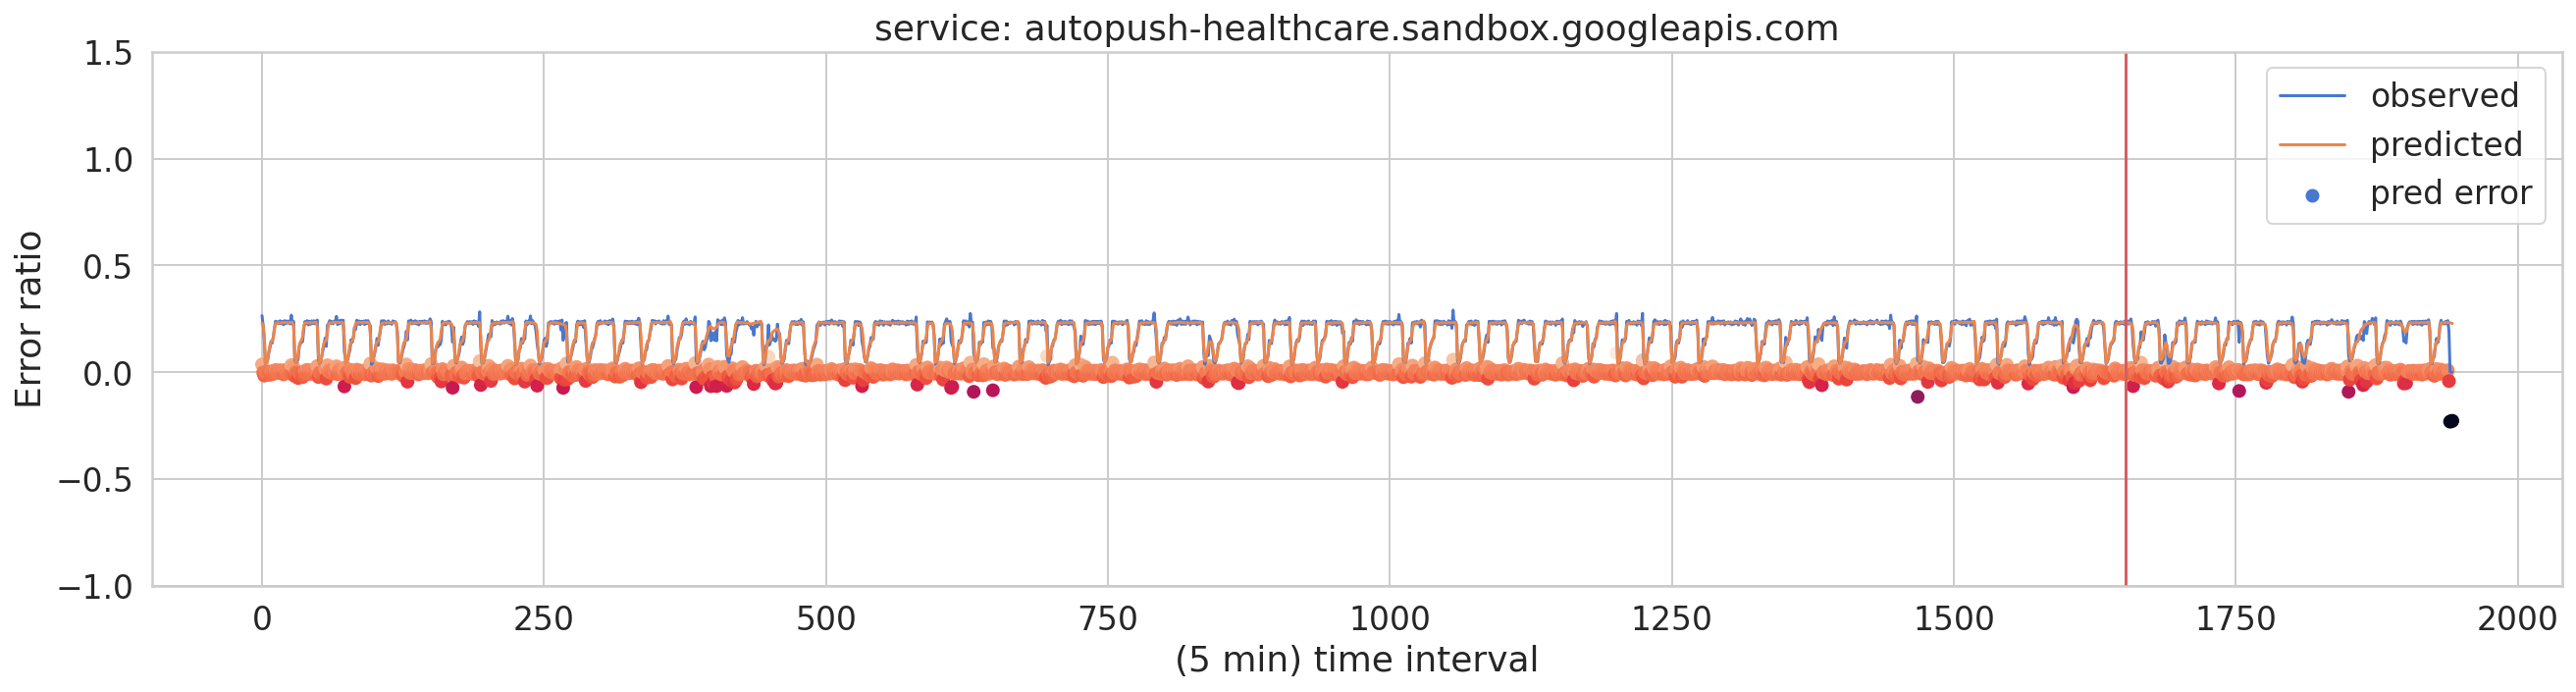

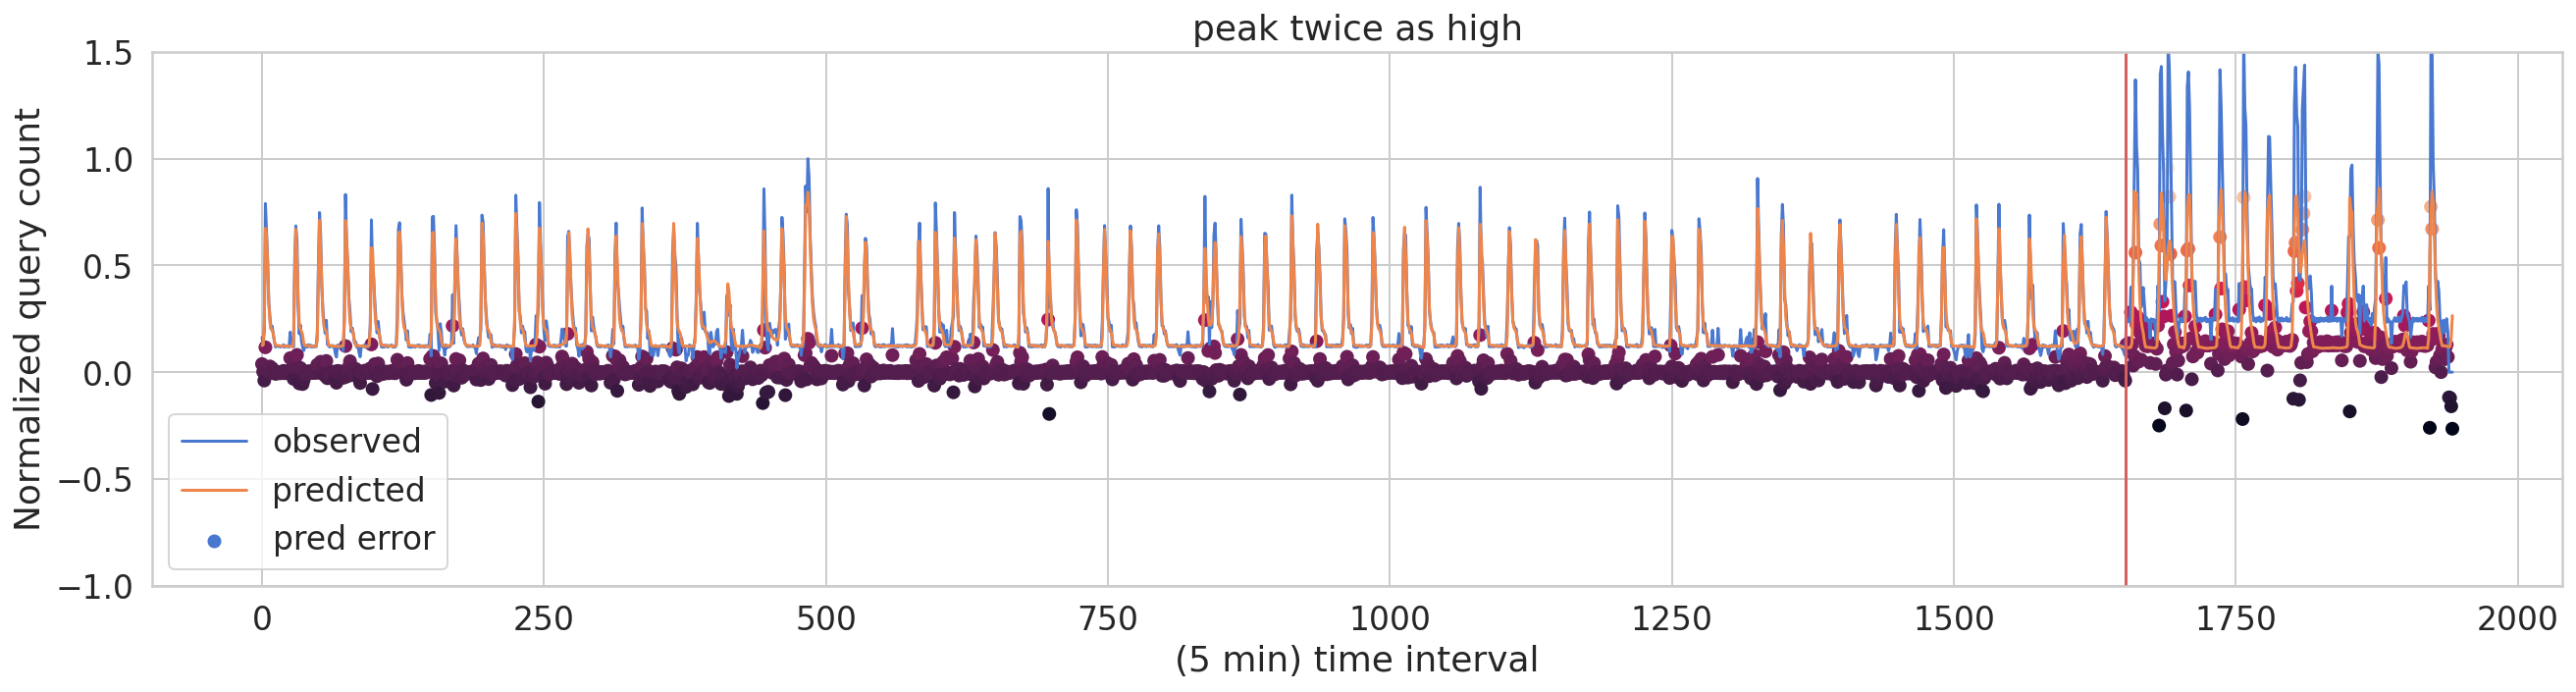

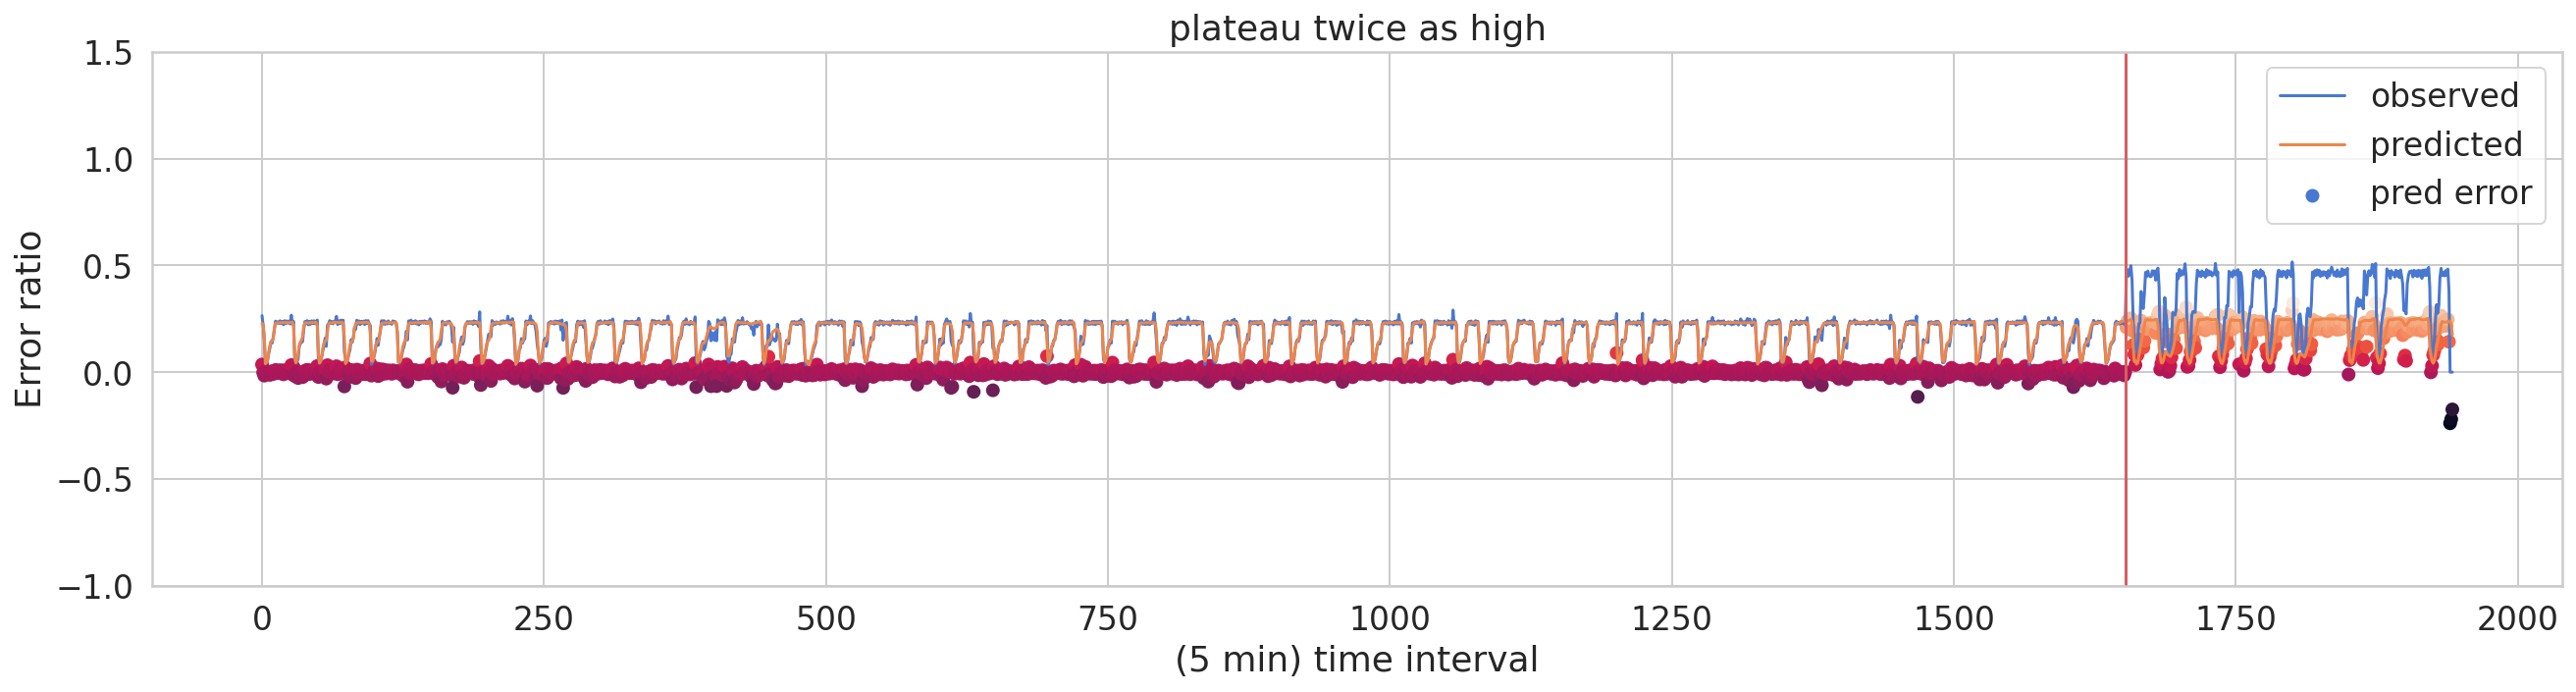

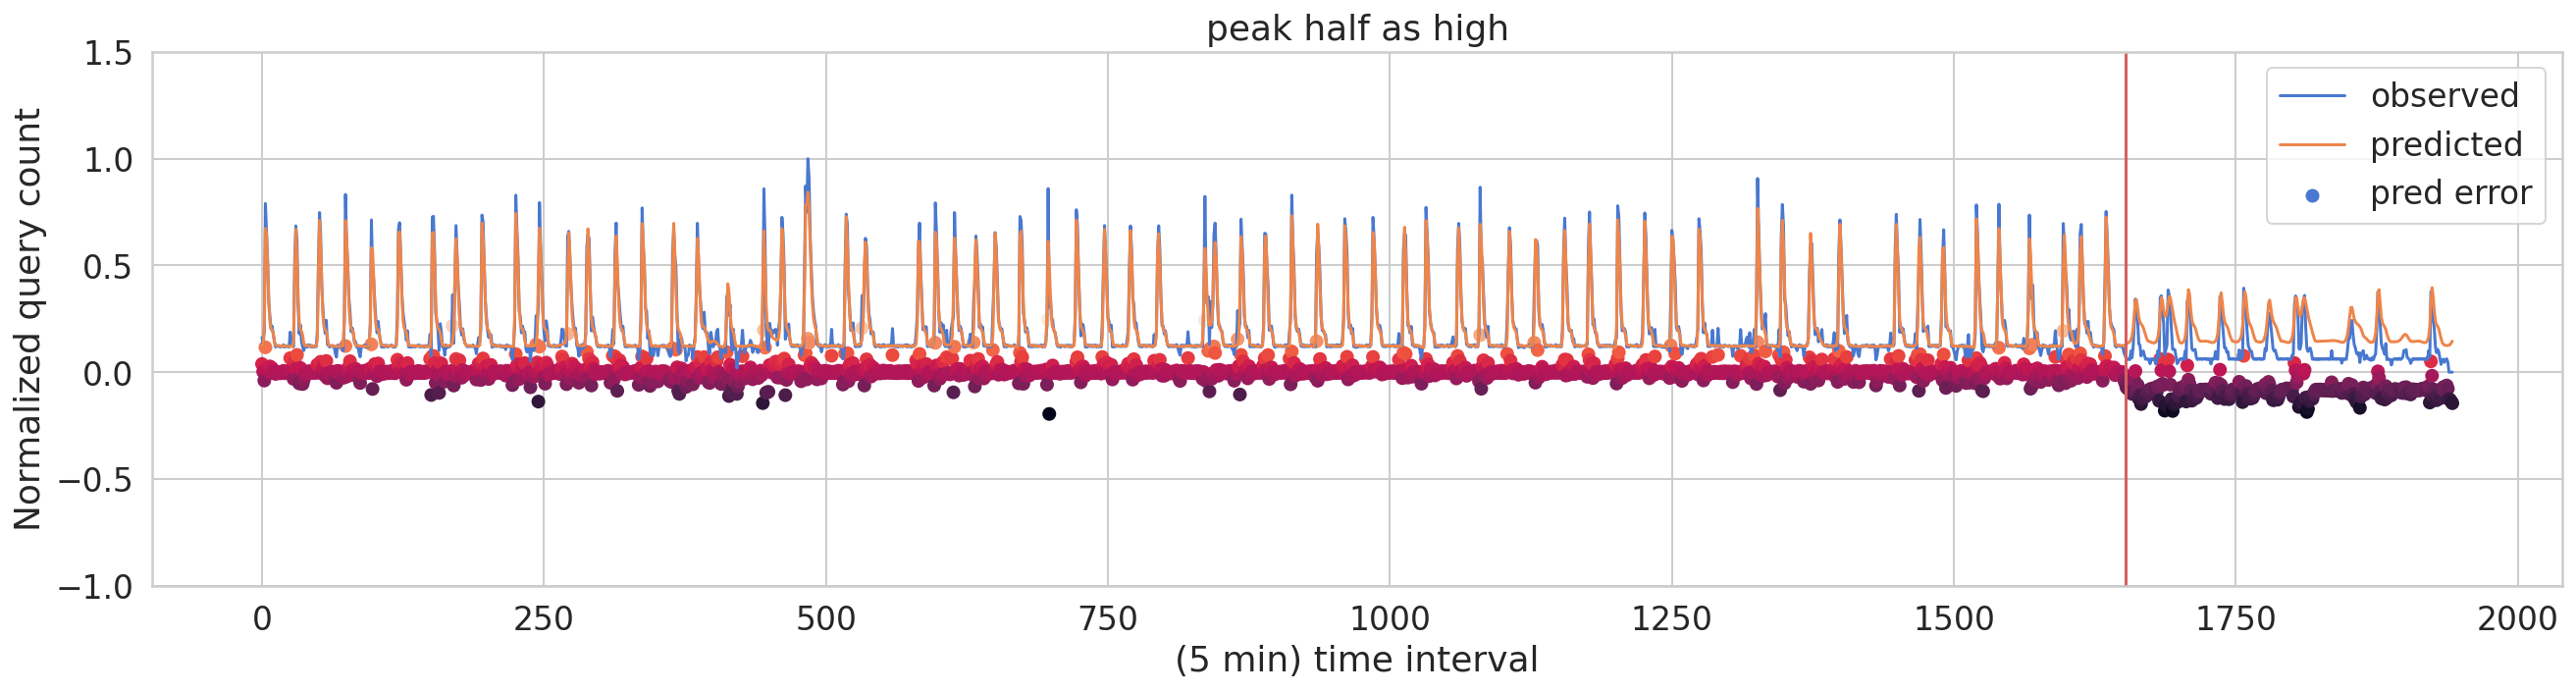

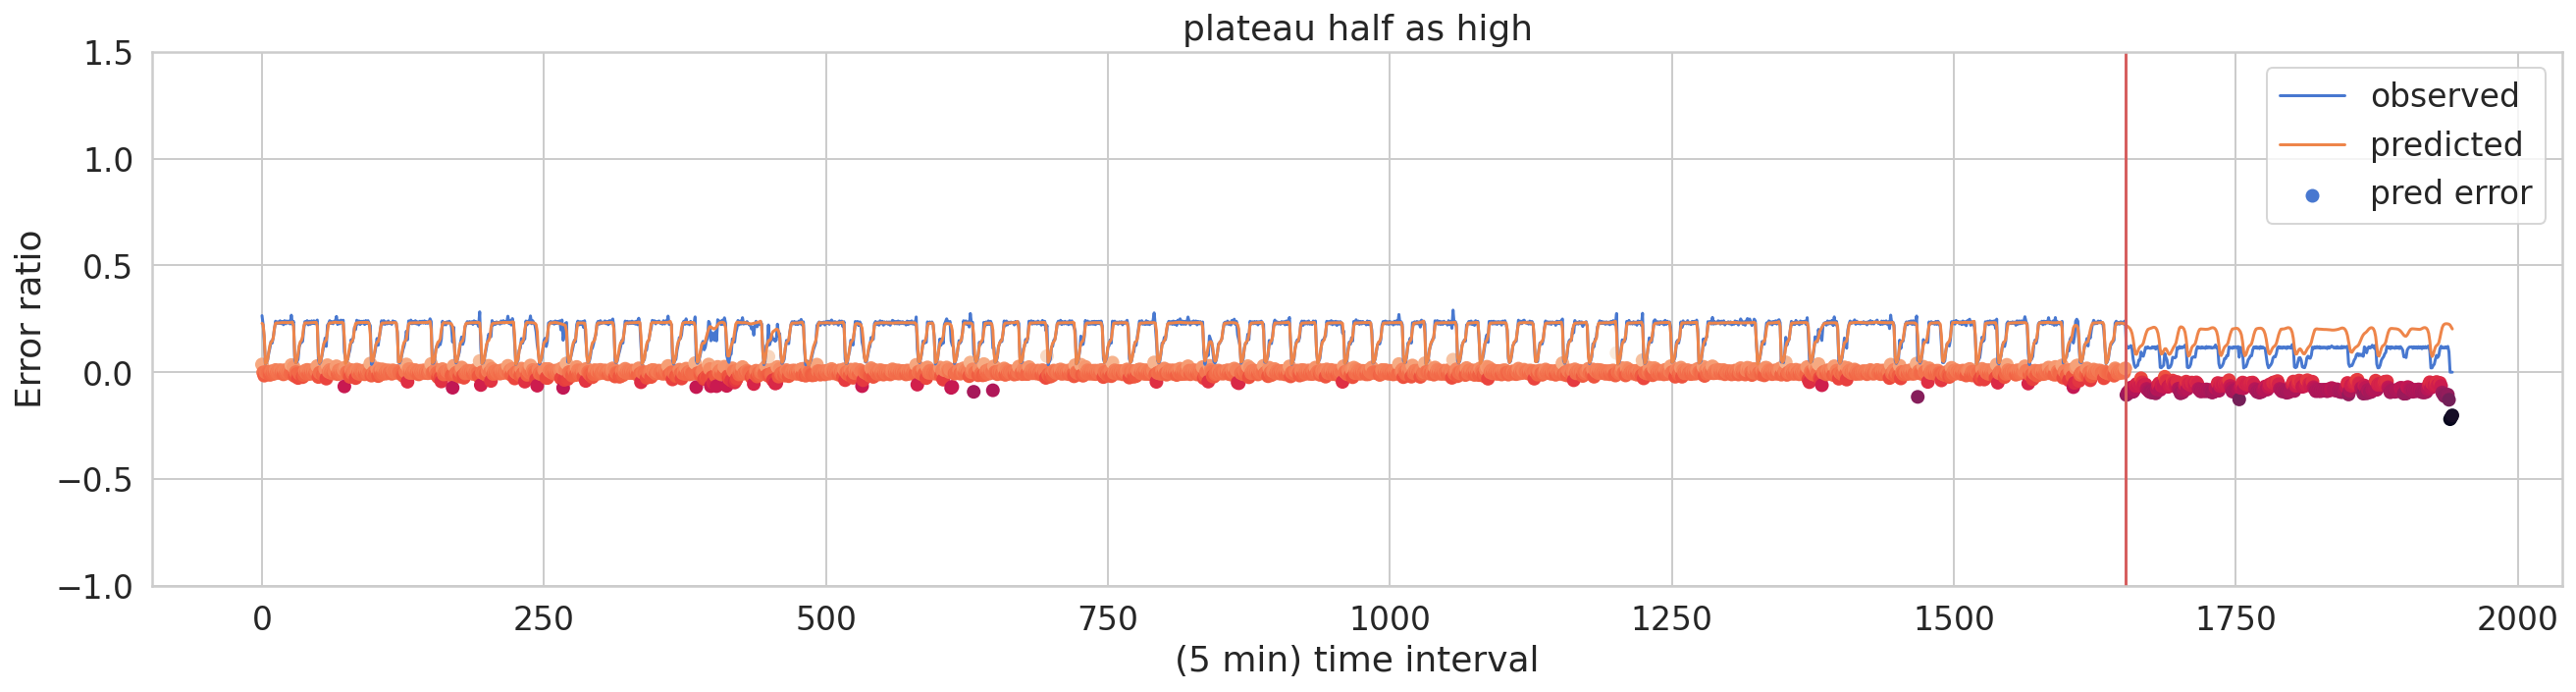

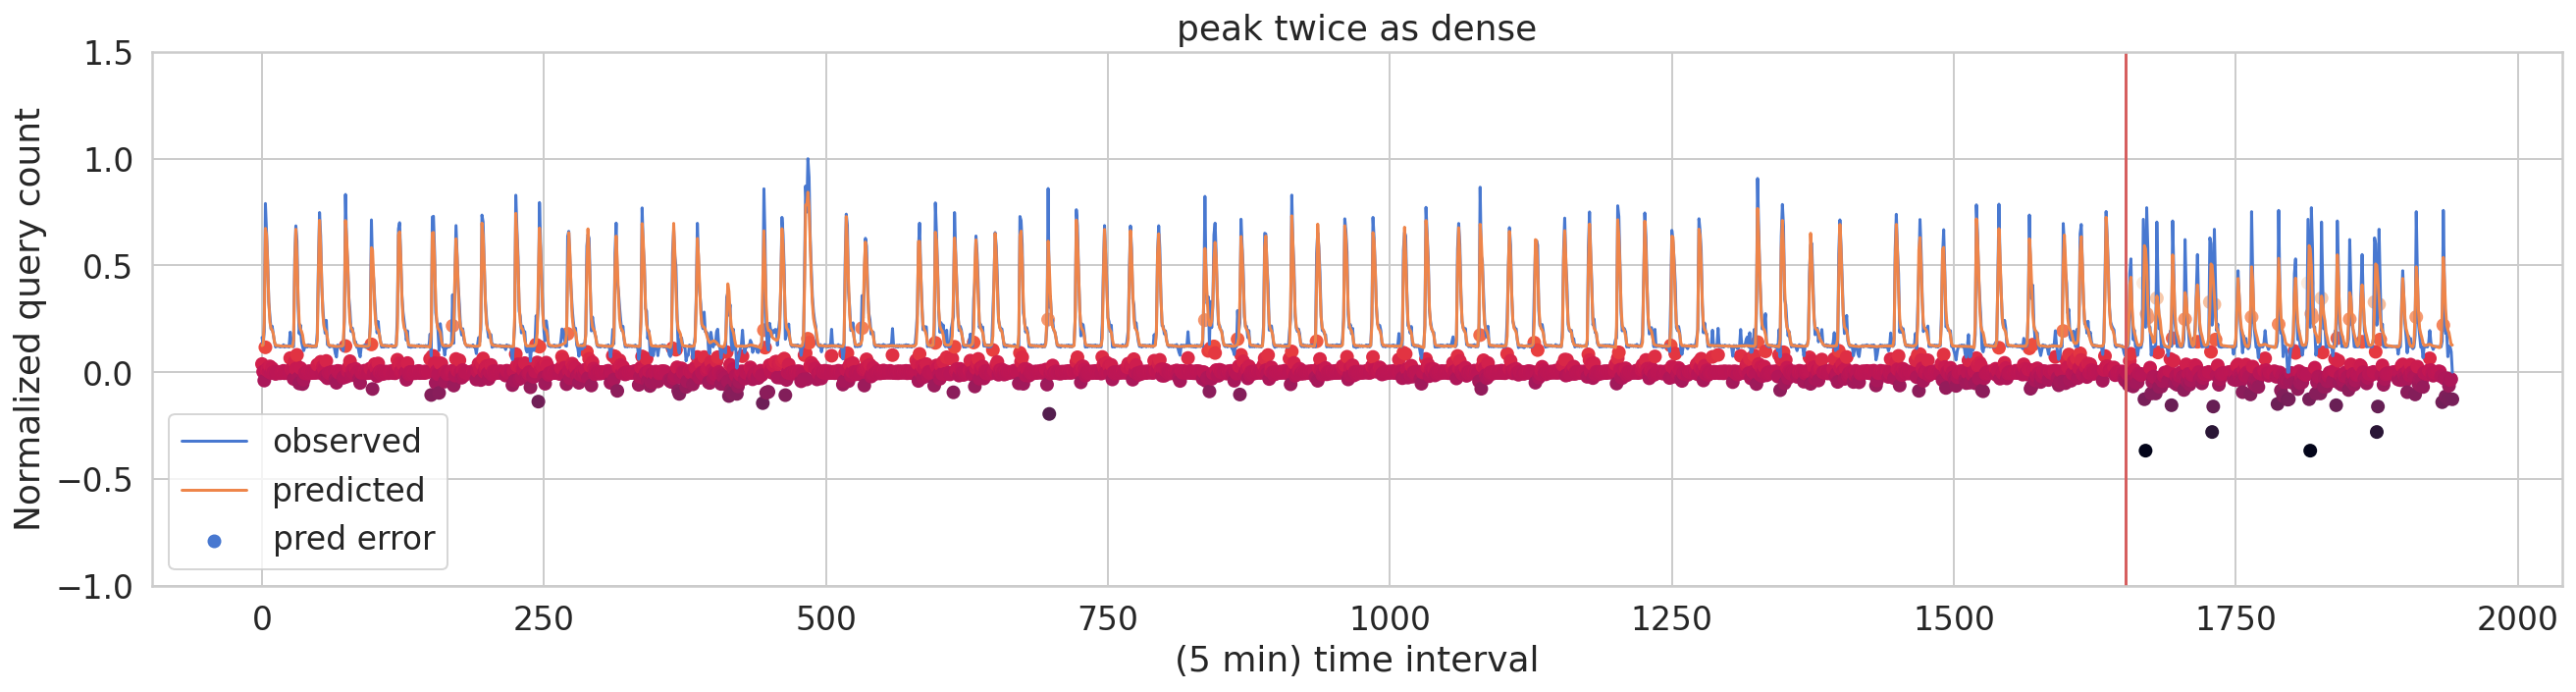

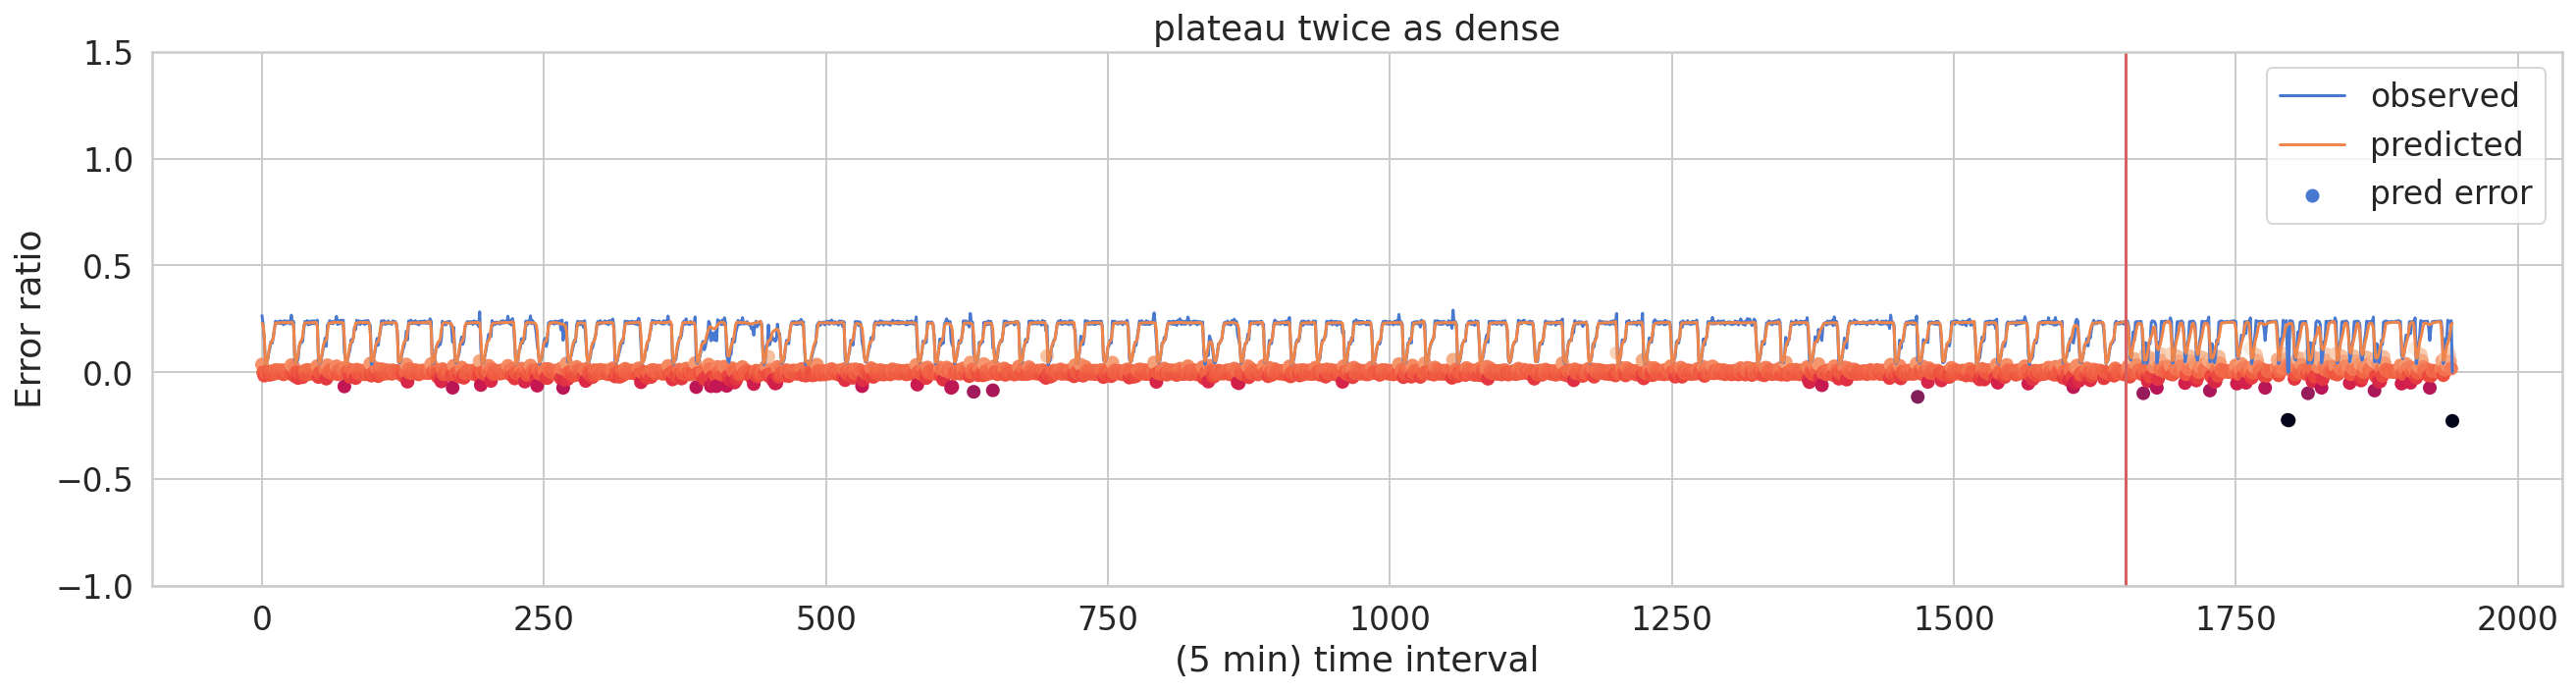

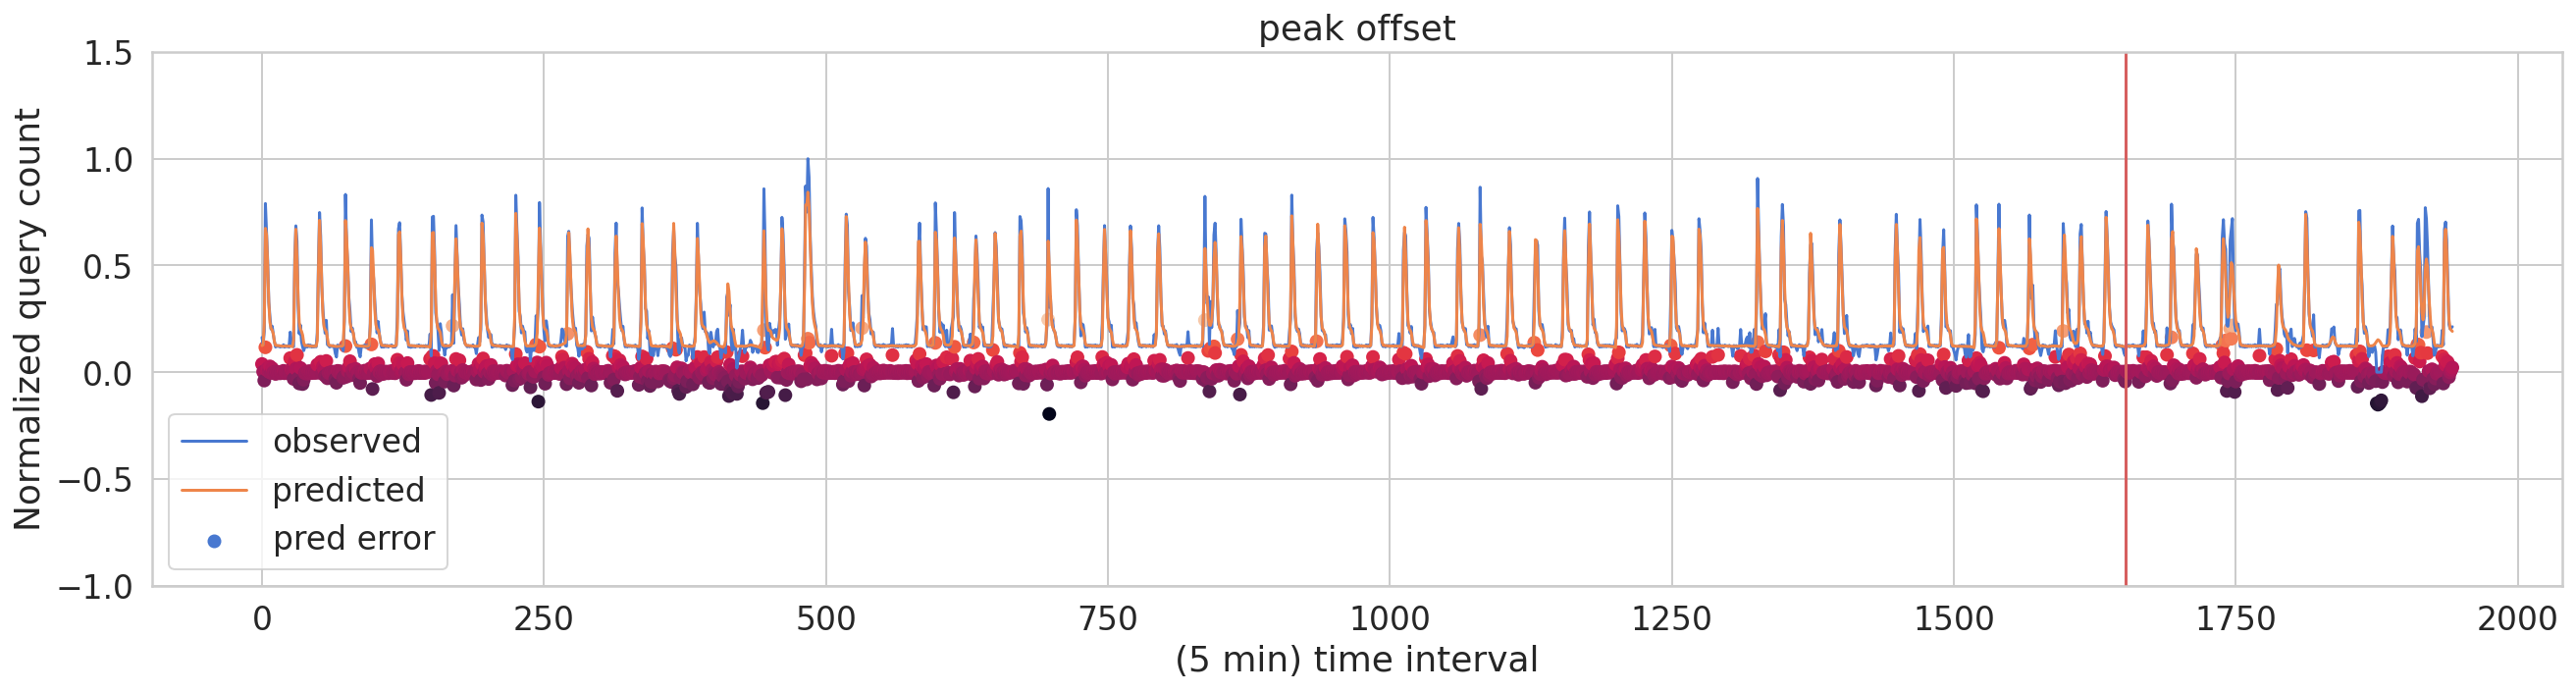

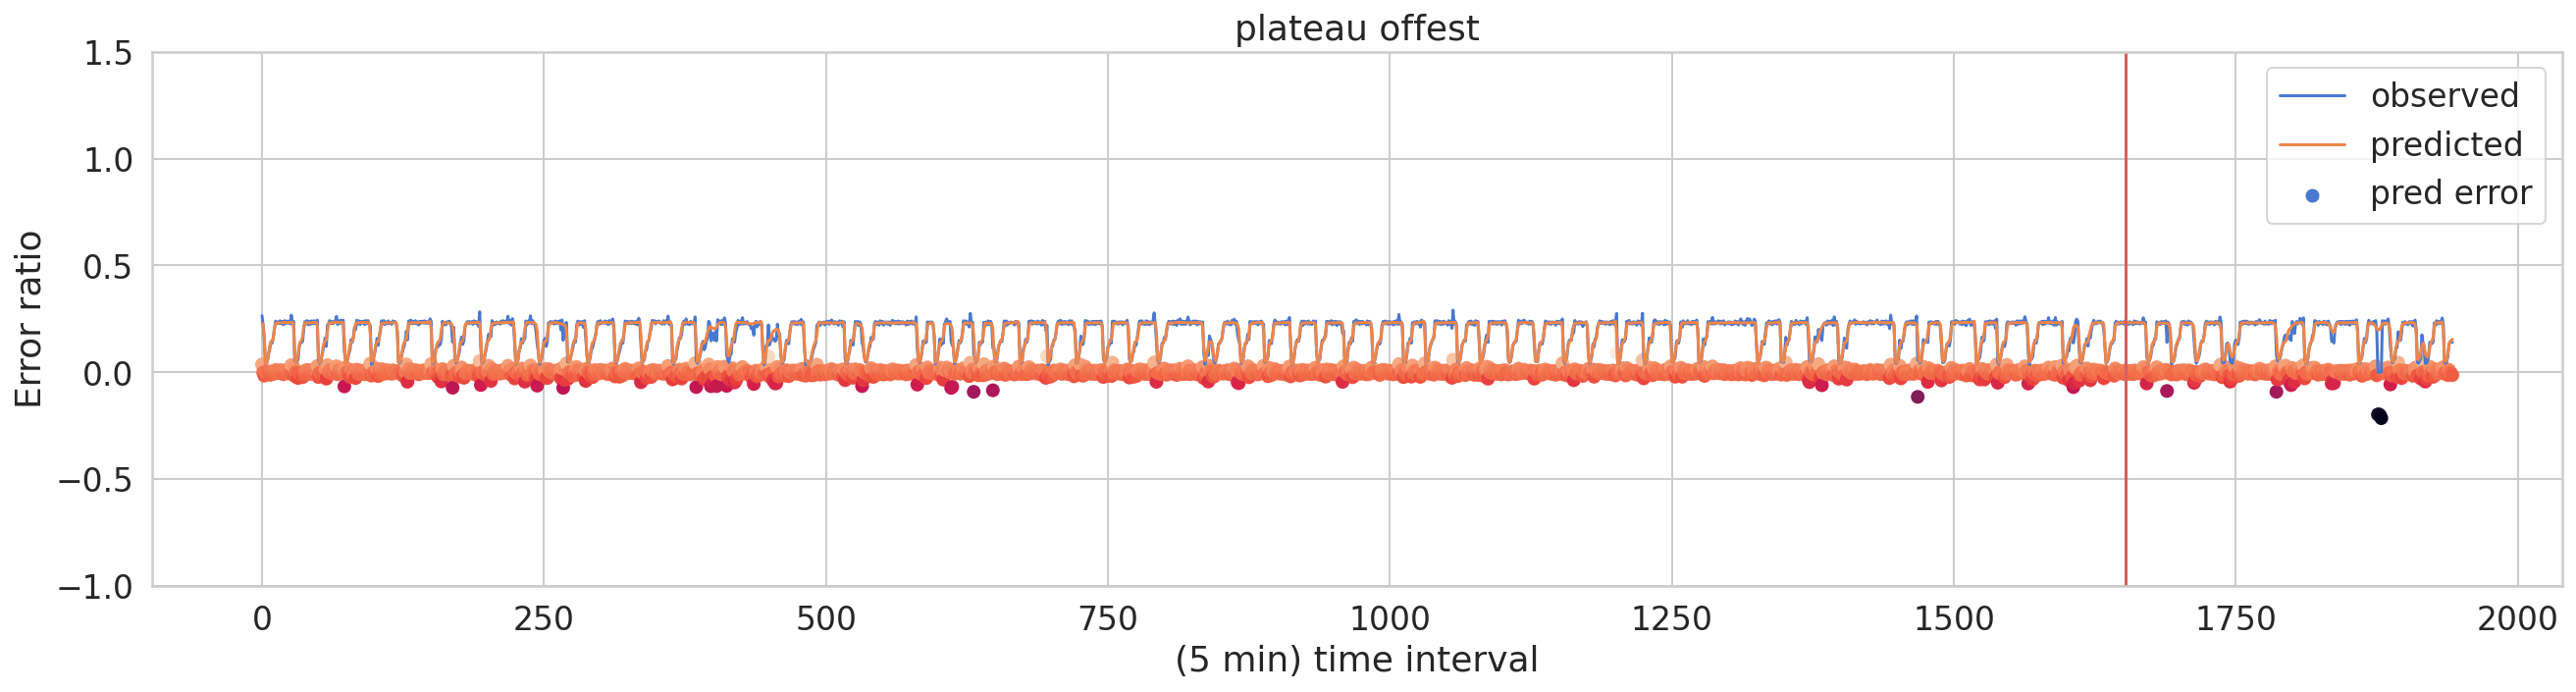

In [18]:
# change both qpi and erorr ratio
make_prediction(data_0=d_0,  data_1=d_1,  titles=[service,               service])
make_prediction(data_0=d_01, data_1=d_11, titles=['peak twice as high',  'plateau twice as high'])
make_prediction(data_0=d_02, data_1=d_12, titles=['peak half as high',   'plateau half as high'])
make_prediction(data_0=d_03, data_1=d_13, titles=['peak twice as dense', 'plateau twice as dense'])
make_prediction(data_0=d_04, data_1=d_14, titles=['peak offset',         'plateau offest'])

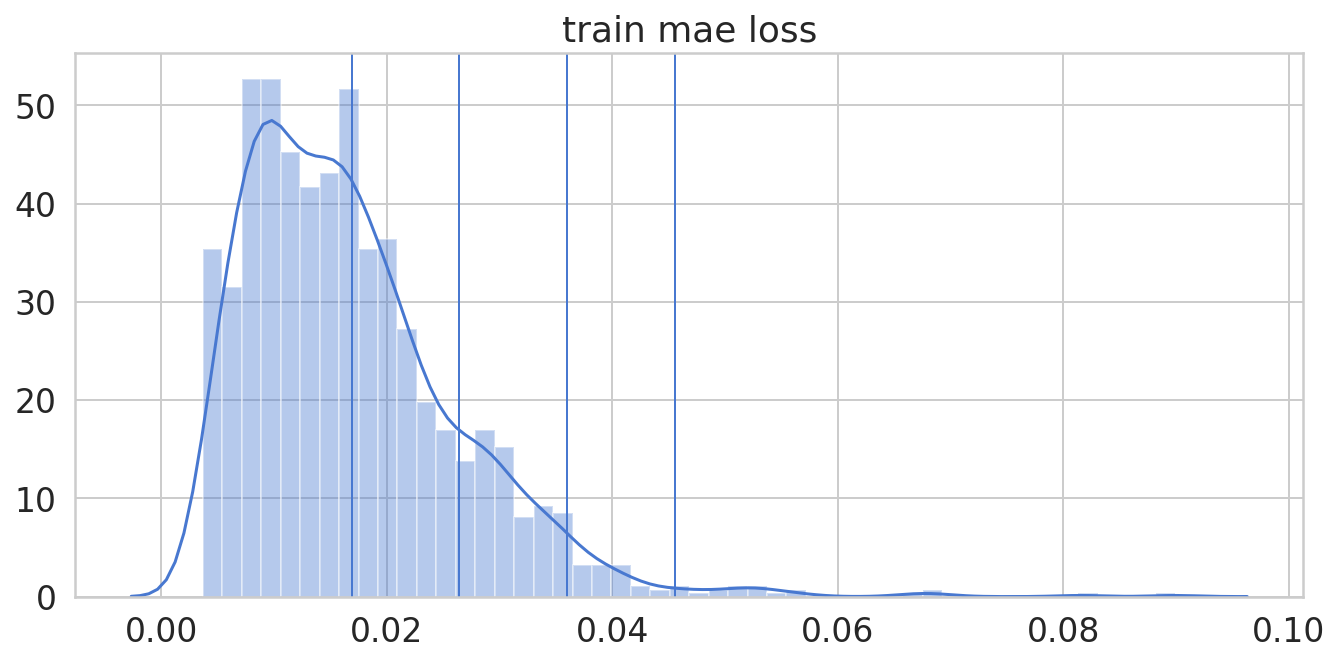

In [19]:
mu, std = train_mae_loss.mean(), train_mae_loss.std()

sns.distplot(train_mae_loss, bins=50, kde=True).set_title('train mae loss')

plt.axvline(mu + 0 * std, color='b', linewidth='1')
plt.axvline(mu + 1 * std, color='b', linewidth='1')
plt.axvline(mu + 2 * std, color='b', linewidth='1')
plt.axvline(mu + 3 * std, color='b', linewidth='1')
plt.show()
    